In [2]:
from imports_func import *
from dbase import *
import os
import pandas as pd

In [3]:
X=np.load('/home/miquel/ForMiquel/CLEAN2/X_c1_c2.npy') 
y=np.load('/home/miquel/ForMiquel/CLEAN2/y.npy') #jacobian labels
y_short=np.load('/home/miquel/ForMiquel/CLEAN2/y_short.npy') #subject labels
sub_id=np.load('/home/miquel/ForMiquel/CLEAN2/sub_id.npy') #jacobian idxs
sub_id_short=np.load('/home/miquel/ForMiquel/CLEAN2/sub_id_short.npy') #subject idxs
dt=np.load('/home/miquel/ForMiquel/CLEAN2/dt.npy') #subject idxs
zeros=np.load('/home/miquel/ForMiquel/CLEAN2/zero_cols_JB_c1_c2.npy') #subject idxs

In [7]:
sub = pd.DataFrame(columns=['ID','label'])

sub['ID'] = sub_id_short
sub['label'] = y_short
print(sub.head())
sub.to_csv('ids_labels_Adria.csv', index=False)

print(len(y_short))
print(len(y))

print(np.sum(y_short))
print(np.sum(y))

   ID  label
0   2      1
1   5      0
2   6      1
3   7      0
4   8      0
124
288
50
114


In [ ]:
X=np.load('/home/miquel/ForMiquel/CLEAN2/X_c1_c2.npy') 
y=np.load('/home/miquel/ForMiquel/CLEAN2/y.npy') #jacobian labels
y_short=np.load('/home/miquel/ForMiquel/CLEAN2/y_short.npy') #subject labels
sub_id=np.load('/home/miquel/ForMiquel/CLEAN2/sub_id.npy') #jacobian idxs
sub_id_short=np.load('/home/miquel/ForMiquel/CLEAN2/sub_id_short.npy') #subject idxs
dt=np.load('/home/miquel/ForMiquel/CLEAN2/dt.npy') #subject idxs
zeros=np.load('/home/miquel/ForMiquel/CLEAN2/zero_cols_JB_c1_c2.npy') #subject idxs

In [3]:
def KFold_intern(X_train, y_train, folds, linspace, y_short_train, sub_id_train, sub_id_intern):
    
    l=len(linspace)
    l2=len(y_short_train)
    TP=np.zeros((l))
    FP=np.zeros((l))
    FN=np.zeros((l))
        

    kf = cross_validation.KFold(l2, n_folds=folds)

    fold = 1
       
    for train_index_f, test_index_f in kf:  
        aux = sub_id_train[train_index_f]
        idx = np.isin(sub_id_intern, aux)
        X_train_f = X_train[idx,:]
        X_test_f = X_train[~idx,:]
        y_train_f = y_train[idx]
        y_test_f = y_train[~idx]
        
        fold = fold + 1
     
        tp_l=[]
        fp_l=[]
        fn_l=[]
        
        for c in linspace:
            
            clf = SVC(kernel='linear', probability = True, class_weight='balanced', C=c)
            #clf = LogisticRegression(solver='liblinear', penalty='l2', C=c, class_weight='balanced')
            clf.fit(X_train_f, y_train_f)
            pred = clf.predict(X_test_f)
            conf = confusion_matrix(y_test_f, pred)
            
            #mask0 = np.where(dt_test_f>1.09)#~400 days
            #mask0 = np.asarray(mask0)
            #pred = pred[mask0][0]
            #y_test_f = y_test_f[mask0][0]
            conf = confusion_matrix(y_test_f, pred)
            tp_l.append(conf[1,1])
            fp_l.append(conf[0,1])
            fn_l.append(conf[1,0])
            
            
        TP = np.vstack((TP, tp_l))
        FP = np.vstack((FP, fp_l))
        FN = np.vstack((FN, fn_l))
        
            
    TP=TP[1:,:]
    FP=FP[1:,:]
    FN=FN[1:,:]
    
    TP=np.sum(TP, axis=0)
    FP=np.sum(FP, axis=0)
    FN=np.sum(FN, axis=0)
    
    F=(2*TP)/(2*TP + FP + FN)
    maxi = np.amax(F)
    maxi_idx = np.argmax(F)
    
    #plt.figure(1)
    #plt.plot(linspace, F, color='blue', label='F-measure')
    #plt.legend(loc='best')
    #plt.xlabel('C')
    #plt.title('metrics logistic regression combination c1 and c2')
    #plt.show()
    
    return maxi, maxi_idx
    


  

In [10]:
def nested_CV_F_measure(X, y, splits, folds, linspace, dt, percentage, y_short, sub_id, sub_id_short, zeros):
   
    box = np.zeros((121,145,121))
    l2=X.shape[1]
    W=np.zeros((l2))

    SPECIFICITY=[]
    PRECISION=[]
    RECALL=[]
    AUC=[]
    F=[]
    ACCURACY=[]
    
    SPECIFICITY1=[]
    PRECISION1=[]
    RECALL1=[]
    AUC1=[]
    F1=[]
    ACCURACY1=[]
    
    tp_l=[]
    fp_l=[]
    fn_l=[]
    
    
    spl = StratifiedShuffleSplit(n_splits=splits, test_size=0.2, random_state=42)
    split=1
    
    for train_index, test_index in spl.split(sub_id_short, y_short): #split in subjects
        sub_id_train = sub_id_short[train_index] #search subject train idxs
        idx = np.isin(sub_id, sub_id_train) #match train idxs 
        X_train = X[idx,:]
        X_test = X[~idx,:]
        y_train = y[idx]
        y_test = y[~idx]
        dt_test = dt[~idx]
        sub_id_intern=sub_id[idx]
        y_short_train=y_short[train_index]
        print("split:", split)
        #print("jacobians at train:", X_train.shape[0])
        split = split + 1
        
        S = SelectPercentile(percentile=percentage)
        S.fit(X_train, y_train)
        scores = np.nan_to_num(S.scores_)
        W = np.vstack((W, scores))
        
        X_train_s = X_train[:,S.get_support()]
        X_test_s = X_test[:,S.get_support()]
     
        maxi, maxi_idx = KFold_intern(X_train_s, y_train, folds, linspace, y_short_train, sub_id_train, sub_id_intern)
        c = linspace[maxi_idx]
        print("C:", c)
        
        #clf = SVC(kernel='linear', probability = True, class_weight='balanced', C=c)
        clf = LogisticRegression(solver='liblinear', penalty='l2', C=c, class_weight='balanced')
        clf.fit(X_train_s, y_train)
        pred = clf.predict(X_test_s)
        probas_ = clf.predict_proba(X_test_s)
        

        probas_ = probas_[:, 1]
        
        #preparation masks to test AUC as function of dt
        mask1 = np.where(dt_test>1000)#~400 days
        mask1 = np.asarray(mask1)
        pred_1 = pred[mask1][0]
        y_test_1 = y_test[mask1][0]
        probas_1 = probas_[mask1][0]
        
        conf = confusion_matrix(y_test, pred)
        print("confusion matrix:", conf)
        tp_l.append(conf[1,1])
        fp_l.append(conf[0,1])
        fn_l.append(conf[1,0])
        
        f1=f1_score(y_test, pred)
        F.append(f1)
        
        f1_1=f1_score(y_test_1, pred_1)
        if np.isnan(f1_1) == False:
            F1.append(f1_1)
        
        
        #print("muestras en test:", len(y_test))
        fpr, tpr, thresholds = roc_curve(y_test, probas_)
        roc_auc = sklearn.metrics.auc(fpr, tpr)
        AUC.append(roc_auc)
        
        #print("muestras en test menos 1 año:", len(y_test_1))
        fpr, tpr, thresholds = roc_curve(y_test_1, probas_1)
        roc_auc_1 = sklearn.metrics.auc(fpr, tpr)
        if np.isnan(roc_auc_1) == False:
            AUC1.append(roc_auc_1)

        precision=precision_score(y_test, pred)
        recall=recall_score(y_test, pred)
        PRECISION.append(precision)
        RECALL.append(recall)
        specificity= (conf[0,0])/(conf[0,0]+conf[0,1])
        SPECIFICITY.append(specificity)
        acc=accuracy_score(y_test, pred)
        ACCURACY.append(acc)
        
        precision1=precision_score(y_test_1, pred_1)
        recall1=recall_score(y_test_1, pred_1)
        PRECISION1.append(precision1)
        RECALL1.append(recall1)
        conf1 = confusion_matrix(y_test_1, pred_1)
        
#         try:
#             a = conf[0,1]
#         except:
#             conf[0,1] = 0
#             print(conf1)
        
#         try:
#             a = conf[1,0]
#         except:
#             conf[1,0] = 0
#             print(conf1)
         
#         try:
#             a = conf[1,1]
#         except:
#             conf[1,1] = 0
#             print(conf1)
            
        print("confusion matrix 1:", conf1)
        try:
            specificity1= (conf1[0,0])/(conf1[0,0]+conf1[0,1])
        except:
            pass
        if np.isnan(specificity1) == False:
            SPECIFICITY1.append(specificity1)
        acc1=accuracy_score(y_test_1, pred_1)
        ACCURACY1.append(acc1)
        
    TP=np.sum(tp_l, axis=0)
    FP=np.sum(fp_l, axis=0)
    FN=np.sum(fn_l, axis=0)

    
    F_g=(2*TP)/(2*TP + FP + FN)
    

    print("ACCURACY_mean:", np.mean(ACCURACY))
    print("PRECISION_mean:", np.mean(PRECISION))
    print("RECALL_mean:", np.mean(RECALL))
    print("SPECIFICITY_mean:", np.mean(SPECIFICITY))
    print("F_mean:", np.mean(F))
    print("AUC_mean:", np.mean(AUC))
    
    print("ACCURACY1_mean:", np.mean(ACCURACY1))
    print("PRECISION1_mean:", np.mean(PRECISION1))
    print("RECALL1_mean:", np.mean(RECALL1))
    print("SPECIFICITY1_mean:", np.mean(SPECIFICITY1))
    print("F1_mean:", np.mean(F1))
    print("AUC1_mean:", np.mean(AUC1))

    print("ACCURACY_std:", np.std(ACCURACY))
    print("PRECISION_std:", np.std(PRECISION))
    print("RECALL_std:", np.std(RECALL))
    print("SPECIFICITY_std:", np.std(SPECIFICITY))
    print("F_std:", np.std(F))
    print("AUC_std:", np.std(AUC))

    print("ACCURACY1_std:", np.std(ACCURACY1))
    print("PRECISION1_std:", np.std(PRECISION1))
    print("RECALL1_std:", np.std(RECALL1))
    print("SPECIFICITY1_std:", np.std(SPECIFICITY1))
    print("F1_std:", np.std(F1))
    print("AUC1_std:", np.std(AUC1))
    
    W=W[1:,:]
    W=np.sum(W, axis=0)
    
    #path = '/home/miquel/ForMiquel/CLEAN2/scores_' + str(splits) + '_' + str(percentage)
    #np.save(path, W)

    return np.mean(F), np.mean(AUC), np.mean(PRECISION), np.mean(RECALL), np.mean(SPECIFICITY), np.mean(ACCURACY), np.std(F), np.std(AUC), np.std(PRECISION), np.std(RECALL), np.std(SPECIFICITY), np.std(ACCURACY),np.mean(F1), np.mean(AUC1), np.mean(PRECISION1), np.mean(RECALL1), np.mean(SPECIFICITY1), np.mean(ACCURACY1), np.std(F1), np.std(AUC1), np.std(PRECISION1), np.std(RECALL1), np.std(SPECIFICITY1), np.std(ACCURACY1)



In [61]:
aux=np.load('/home/miquel/ForMiquel/CLEAN2/scores_100_0.35.npy') 
#aux = np.sum(W, axis=0)
zero_cols=np.load('/home/miquel/ForMiquel/CLEAN2/zero_cols_JB_c1_c2.npy')
v = np.zeros((121*145*121,)) 
v[~zero_cols]=np.reshape(aux,(len(aux),)) #put pvalues in corresponding positions
img = np.reshape(v, (121,145,121)) #reshape to original image shape
img = np.transpose(img)
np.save('/home/miquel/ForMiquel/CLEAN2/scores_100_0.35', img)
new_img = nib.Nifti1Image(img, np.eye(4))
nib.save(new_img, "scores_100_0.35_img.nii.gz")

In [11]:
splits = 100
folds= 3
linspace = np.linspace(10e-4, 10e-1, num=10)
percentage = 0.35
F, AUC, PRECISION, RECALL, SPECIFICITY, ACCURACY, Fs, AUCs, PRECISIONs, RECALLs, SPECIFICITYs, ACCURACYs, F1, AUC1, PRECISION1, RECALL1, SPECIFICITY1, ACCURACY1, F1s, AUC1s, PRECISION1s, RECALL1s, SPECIFICITY1s, ACCURACY1s = nested_CV_F_measure(X, y, splits, folds, linspace, dt, percentage, y_short, sub_id, sub_id_short, zeros)
os.system('espeak "la ejecución ha terminadoooooooooooooooooooooooooo"')

split: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    180 ..., 580922 580925 580926] are constant.
  UserWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


C: 0.445
confusion matrix: [[15  6]
 [ 9 10]]
confusion matrix 1: [[0 1]
 [1 4]]
split: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   354    426    546 ..., 580917 580918 580919] are constant.
  UserWarning)


C: 0.556
confusion matrix: [[34  6]
 [18 10]]
confusion matrix 1: [[9 3]
 [0 5]]
split: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   295    303    317 ..., 580917 580918 580919] are constant.
  UserWarning)


C: 0.778
confusion matrix: [[37 19]
 [ 7 12]]
confusion matrix 1: [[ 8 14]
 [ 0  5]]
split: 4


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   402    426    451 ..., 580922 580925 580926] are constant.
  UserWarning)


C: 0.334
confusion matrix: [[30 11]
 [ 8  7]]
confusion matrix 1: [[9 5]
 [0 4]]
split: 5


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   295    303    312 ..., 580895 580896 580897] are constant.
  UserWarning)


C: 0.556
confusion matrix: [[26 18]
 [11 10]]
confusion matrix 1: [[ 2 11]
 [ 3  5]]
split: 6


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   151    287    357 ..., 580885 580886 580887] are constant.
  UserWarning)


C: 1.0
confusion matrix: [[26 12]
 [ 8 16]]
confusion matrix 1: [[7 7]
 [0 8]]
split: 7


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    85    129    140 ..., 580903 580904 580905] are constant.
  UserWarning)


C: 0.334
confusion matrix: [[29 24]
 [11 13]]
confusion matrix 1: [[ 2 17]
 [ 0  6]]
split: 8


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   187    192    193 ..., 580886 580887 580924] are constant.
  UserWarning)


C: 0.334
confusion matrix: [[19  2]
 [16 12]]
confusion matrix 1: [[0 1]
 [3 6]]
split: 9


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   180    181    185 ..., 580913 580914 580915] are constant.
  UserWarning)


C: 0.556
confusion matrix: [[18  3]
 [12 17]]
confusion matrix 1: [[ 2  1]
 [ 0 12]]
split: 10


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   334    347    354 ..., 580913 580914 580915] are constant.
  UserWarning)


C: 0.556
confusion matrix: [[26  6]
 [11  6]]
confusion matrix 1: [[6 4]
 [0 4]]
split: 11


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   151    295    303 ..., 580913 580914 580915] are constant.
  UserWarning)


C: 1.0
confusion matrix: [[30 14]
 [12 23]]
confusion matrix 1: [[ 7 10]
 [ 0 13]]
split: 12


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   207    402    483 ..., 580922 580925 580926] are constant.
  UserWarning)


C: 1.0
confusion matrix: [[37 15]
 [12  9]]
confusion matrix 1: [[11 11]
 [ 0  3]]
split: 13


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   334    347    387 ..., 580876 580888 580889] are constant.
  UserWarning)


C: 0.778
confusion matrix: [[24  8]
 [13  8]]
confusion matrix 1: [[6 5]
 [0 3]]
split: 14


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    207 ..., 580922 580925 580926] are constant.
  UserWarning)


C: 0.667
confusion matrix: [[22 11]
 [ 7 13]]
confusion matrix 1: [[2 7]
 [0 7]]
split: 15


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   295    303    319 ..., 580786 580800 580815] are constant.
  UserWarning)


C: 0.667
confusion matrix: [[26 14]
 [13 11]]
confusion matrix 1: [[ 3 10]
 [ 0  6]]
split: 16


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   180    181    185 ..., 580917 580918 580919] are constant.
  UserWarning)


C: 0.667
confusion matrix: [[34  5]
 [13 15]]
confusion matrix 1: [[11  3]
 [ 0  8]]
split: 17


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    400 ..., 580895 580896 580897] are constant.
  UserWarning)


C: 0.445
confusion matrix: [[18  8]
 [ 9  3]]
confusion matrix 1: [[2 2]
 [1 1]]
split: 18


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   207    334    347 ..., 580865 580877 580881] are constant.
  UserWarning)


C: 0.445
confusion matrix: [[18 12]
 [12  5]]
confusion matrix 1: [[2 4]
 [0 1]]
split: 19


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   180    181    185 ..., 580786 580800 580815] are constant.
  UserWarning)


C: 0.112
confusion matrix: [[25 20]
 [ 6  6]]
confusion matrix 1: [[ 0 10]
 [ 0  1]]
split: 20


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   177    182    187 ..., 580914 580915 580924] are constant.
  UserWarning)


C: 1.0
confusion matrix: [[17 10]
 [10 12]]
confusion matrix 1: [[0 4]
 [1 7]]
split: 21


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    129 ..., 580917 580918 580919] are constant.
  UserWarning)


C: 0.889
confusion matrix: [[31 12]
 [11  6]]
confusion matrix 1: [[7 7]
 [2 3]]
split: 22


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   334    347    357 ..., 580752 580753 580857] are constant.
  UserWarning)


C: 0.889
confusion matrix: [[24 10]
 [ 8 28]]
confusion matrix 1: [[ 2  8]
 [ 2 14]]
split: 23


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    180 ..., 580903 580904 580905] are constant.
  UserWarning)


C: 0.223
confusion matrix: [[14  1]
 [11  6]]


/usr/local/lib/python3.4/dist-packages/sklearn/metrics/ranking.py:563: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


confusion matrix 1: [[3]]
split: 24


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 580920 580921 580924] are constant.
  UserWarning)


C: 1.0
confusion matrix: [[25 10]
 [ 7  7]]
confusion matrix 1: [[5 8]
 [1 2]]
split: 25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    293 ..., 580876 580888 580889] are constant.
  UserWarning)


C: 0.556
confusion matrix: [[29 12]
 [ 9 13]]
confusion matrix 1: [[5 8]
 [0 6]]
split: 26


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    237 ..., 580902 580906 580907] are constant.
  UserWarning)


C: 0.334
confusion matrix: [[28  9]
 [22 19]]
confusion matrix 1: [[ 5  5]
 [ 3 10]]
split: 27


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   151    287    334 ..., 580902 580906 580907] are constant.
  UserWarning)


C: 0.778
confusion matrix: [[21  5]
 [13  8]]
confusion matrix 1: [[1 5]
 [2 3]]
split: 28


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    357 ..., 580895 580896 580897] are constant.
  UserWarning)


C: 0.778
confusion matrix: [[27 11]
 [ 8  4]]


/usr/local/lib/python3.4/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.4/dist-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


confusion matrix 1: [[6 7]
 [0 0]]
split: 29


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    151 ..., 580903 580904 580905] are constant.
  UserWarning)


C: 0.445
confusion matrix: [[28 12]
 [14  7]]
confusion matrix 1: [[5 8]
 [4 4]]
split: 30


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   151    207    357 ..., 580922 580925 580926] are constant.
  UserWarning)


C: 0.667
confusion matrix: [[25  6]
 [ 9 24]]
confusion matrix 1: [[ 6  3]
 [ 1 14]]
split: 31


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   151    187    192 ..., 580924 580925 580926] are constant.
  UserWarning)


C: 0.556
confusion matrix: [[19  5]
 [11 13]]
confusion matrix 1: [[4 2]
 [3 7]]
split: 32


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    237 ..., 580895 580896 580897] are constant.
  UserWarning)


C: 0.556
confusion matrix: [[22 16]
 [10 23]]
confusion matrix 1: [[ 2  9]
 [ 0 11]]
split: 33


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    237 ..., 580913 580914 580915] are constant.
  UserWarning)


C: 0.889
confusion matrix: [[24 12]
 [11  8]]
confusion matrix 1: [[5 6]
 [0 3]]
split: 34


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   151    180    181 ..., 580607 580653 580670] are constant.
  UserWarning)


C: 0.556
confusion matrix: [[23 19]
 [13 20]]
confusion matrix 1: [[ 3 15]
 [ 2 10]]
split: 35


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    180 ..., 580922 580925 580926] are constant.
  UserWarning)


C: 1.0
confusion matrix: [[22  9]
 [12 15]]
confusion matrix 1: [[3 7]
 [0 7]]
split: 36


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    151 ..., 580857 580865 580877] are constant.
  UserWarning)


C: 0.889
confusion matrix: [[23 13]
 [ 8  6]]
confusion matrix 1: [[4 7]
 [0 0]]
split: 37


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   151    180    181 ..., 580922 580925 580926] are constant.
  UserWarning)


C: 0.556
confusion matrix: [[28  9]
 [19  9]]
confusion matrix 1: [[8 7]
 [3 5]]
split: 38


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   334    347    415 ..., 580917 580918 580919] are constant.
  UserWarning)


C: 0.556
confusion matrix: [[25  8]
 [12 21]]
confusion matrix 1: [[ 9  3]
 [ 2 13]]
split: 39


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   402    439    547 ..., 580922 580925 580926] are constant.
  UserWarning)


C: 0.778
confusion matrix: [[20  6]
 [14 12]]
confusion matrix 1: [[3 3]
 [1 7]]
split: 40


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   151    402    403 ..., 580751 580752 580753] are constant.
  UserWarning)


C: 0.889
confusion matrix: [[17 15]
 [ 9 10]]
confusion matrix 1: [[ 2 10]
 [ 2  4]]
split: 41


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    237 ..., 580917 580918 580919] are constant.
  UserWarning)


C: 0.445
confusion matrix: [[29 38]
 [12 32]]
confusion matrix 1: [[ 5 22]
 [ 0 18]]
split: 42


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   175    176    269 ..., 580913 580914 580915] are constant.
  UserWarning)


C: 0.778
confusion matrix: [[20  8]
 [16 21]]
confusion matrix 1: [[ 1  6]
 [ 1 13]]
split: 43


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    198 ..., 580903 580904 580905] are constant.
  UserWarning)


C: 0.667
confusion matrix: [[19 10]
 [11 13]]
confusion matrix 1: [[2 3]
 [0 6]]
split: 44


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   287    357    358 ..., 580917 580918 580919] are constant.
  UserWarning)


C: 0.223
confusion matrix: [[19  5]
 [10 20]]
confusion matrix 1: [[5 3]
 [0 9]]
split: 45
C: 0.667
confusion matrix: [[23  8]
 [11  8]]
confusion matrix 1: [[4 5]
 [1 4]]
split: 46
C: 0.667
confusion matrix: [[21 10]
 [ 7  8]]
confusion matrix 1: [[0 6]
 [0 3]]
split: 47


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   187    192    193 ..., 580914 580915 580924] are constant.
  UserWarning)


C: 0.223
confusion matrix: [[19  7]
 [10 14]]
confusion matrix 1: [[1 3]
 [2 8]]
split: 48


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   317    318    334 ..., 580913 580914 580915] are constant.
  UserWarning)


C: 0.001
confusion matrix: [[ 3 25]
 [ 2 15]]
confusion matrix 1: [[0 5]
 [0 2]]
split: 49


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    334 ..., 580917 580918 580919] are constant.
  UserWarning)


C: 0.667
confusion matrix: [[32 15]
 [ 7  8]]
confusion matrix 1: [[ 9 12]
 [ 0  3]]
split: 50
C: 0.334
confusion matrix: [[26 11]
 [ 7  5]]
confusion matrix 1: [[6 6]
 [2 0]]
split: 51


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   177    182    187 ..., 580846 580857 580924] are constant.
  UserWarning)


C: 0.001
confusion matrix: [[ 5 51]
 [ 2 13]]
confusion matrix 1: [[ 3 18]
 [ 0  3]]
split: 52


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   151    175    176 ..., 580902 580906 580907] are constant.
  UserWarning)


C: 0.889
confusion matrix: [[32 12]
 [17 23]]
confusion matrix 1: [[ 7  9]
 [ 4 15]]
split: 53


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   151    207    295 ..., 580922 580925 580926] are constant.
  UserWarning)


C: 0.667
confusion matrix: [[41  9]
 [15 11]]
confusion matrix 1: [[11  8]
 [ 2  8]]
split: 54
C: 1.0
confusion matrix: [[37 18]
 [17 16]]
confusion matrix 1: [[ 9 11]
 [ 2  9]]
split: 55


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   177    182    187 ..., 580906 580907 580924] are constant.
  UserWarning)


C: 0.334
confusion matrix: [[16  3]
 [15  8]]
confusion matrix 1: [[0 2]
 [3 4]]
split: 56


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    151 ..., 580895 580896 580897] are constant.
  UserWarning)


C: 0.778
confusion matrix: [[22 11]
 [13  9]]
confusion matrix 1: [[3 5]
 [1 7]]
split: 57


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   287    400    401 ..., 580903 580904 580905] are constant.
  UserWarning)


C: 0.112
confusion matrix: [[20 19]
 [11 11]]
confusion matrix 1: [[ 1 13]
 [ 0  7]]
split: 58


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   287    387    482 ..., 580917 580918 580919] are constant.
  UserWarning)


C: 0.667
confusion matrix: [[22 13]
 [22 18]]
confusion matrix 1: [[6 7]
 [6 8]]
split: 59


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   312    313    314 ..., 580913 580914 580915] are constant.
  UserWarning)


C: 0.778
confusion matrix: [[29  6]
 [11  5]]
confusion matrix 1: [[8 5]
 [4 0]]
split: 60


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    237 ..., 580922 580925 580926] are constant.
  UserWarning)


C: 0.889
confusion matrix: [[29  8]
 [11  8]]
confusion matrix 1: [[5 6]
 [2 2]]
split: 61


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   151    180    181 ..., 580913 580914 580915] are constant.
  UserWarning)


C: 0.223
confusion matrix: [[27 17]
 [ 5  7]]
confusion matrix 1: [[ 3 11]
 [ 0  2]]
split: 62
C: 0.778
confusion matrix: [[27  9]
 [ 9  8]]
confusion matrix 1: [[8 5]
 [0 3]]
split: 63


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   179    187    192 ..., 580914 580915 580924] are constant.
  UserWarning)


C: 1.0
confusion matrix: [[26  7]
 [12  5]]
confusion matrix 1: [[6 4]
 [2 1]]
split: 64


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    179 ..., 580914 580915 580924] are constant.
  UserWarning)


C: 0.889
confusion matrix: [[22 15]
 [11 10]]
confusion matrix 1: [[3 7]
 [2 5]]
split: 65


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   387    400    401 ..., 580565 580865 580877] are constant.
  UserWarning)


C: 1.0
confusion matrix: [[24  9]
 [14  4]]
confusion matrix 1: [[8 3]
 [1 1]]
split: 66
C: 0.223
confusion matrix: [[26  5]
 [15  8]]
confusion matrix 1: [[1 2]
 [2 4]]
split: 67


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    187 ..., 580924 580925 580926] are constant.
  UserWarning)


C: 0.556
confusion matrix: [[20  8]
 [10  4]]
confusion matrix 1: [[4 4]
 [1 1]]
split: 68


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   287    295    303 ..., 580902 580906 580907] are constant.
  UserWarning)


C: 0.223
confusion matrix: [[18 16]
 [ 8 11]]
confusion matrix 1: [[0 8]
 [0 5]]
split: 69


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    177 ..., 580914 580915 580924] are constant.
  UserWarning)


C: 1.0
confusion matrix: [[26  5]
 [13 11]]
confusion matrix 1: [[2 3]
 [0 6]]
split: 70


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   207    354    402 ..., 580913 580914 580915] are constant.
  UserWarning)


C: 1.0
confusion matrix: [[22  6]
 [14 12]]
confusion matrix 1: [[4 3]
 [0 9]]
split: 71


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   151    180    181 ..., 580917 580918 580919] are constant.
  UserWarning)


C: 0.889
confusion matrix: [[19  5]
 [ 9  8]]
confusion matrix 1: [[4 2]
 [0 1]]
split: 72


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   151    179    187 ..., 580906 580907 580924] are constant.
  UserWarning)


C: 1.0
confusion matrix: [[22 13]
 [ 9 17]]
confusion matrix 1: [[1 9]
 [0 8]]
split: 73
C: 0.556
confusion matrix: [[23  6]
 [11  5]]
confusion matrix 1: [[5 4]
 [1 1]]
split: 74


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   354    404    426 ..., 580922 580925 580926] are constant.
  UserWarning)


C: 1.0
confusion matrix: [[33 21]
 [11 16]]
confusion matrix 1: [[ 4 15]
 [ 2  8]]
split: 75


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   295    303    312 ..., 580922 580925 580926] are constant.
  UserWarning)


C: 0.112
confusion matrix: [[20 20]
 [ 9  5]]
confusion matrix 1: [[ 1 13]
 [ 1  1]]
split: 76


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   354    482    523 ..., 580922 580925 580926] are constant.
  UserWarning)


C: 0.445
confusion matrix: [[22  1]
 [15 19]]
confusion matrix 1: [[1 0]
 [2 9]]
split: 77


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    177 ..., 580914 580915 580924] are constant.
  UserWarning)


C: 0.112
confusion matrix: [[17  7]
 [ 7  5]]
confusion matrix 1: [[0 2]
 [1 0]]
split: 78


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   180    181    185 ..., 580920 580921 580924] are constant.
  UserWarning)


C: 0.556
confusion matrix: [[31  5]
 [10 10]]
confusion matrix 1: [[7 2]
 [0 6]]
split: 79
C: 0.889
confusion matrix: [[24 14]
 [15 18]]
confusion matrix 1: [[ 3 10]
 [ 0 10]]
split: 80


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   295    303    319 ..., 580815 580831 580881] are constant.
  UserWarning)


C: 1.0
confusion matrix: [[31 12]
 [ 8  9]]
confusion matrix 1: [[ 3 11]
 [ 0  4]]
split: 81
C: 0.112
confusion matrix: [[25 21]
 [ 7 12]]
confusion matrix 1: [[ 1 13]
 [ 0  3]]
split: 82
C: 0.334
confusion matrix: [[30 18]
 [17 20]]
confusion matrix 1: [[ 5 10]
 [ 1 11]]
split: 83


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 580902 580906 580907] are constant.
  UserWarning)


C: 1.0
confusion matrix: [[19  4]
 [15 16]]
confusion matrix 1: [[1 1]
 [2 8]]
split: 84


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   293    294    402 ..., 580903 580904 580905] are constant.
  UserWarning)


C: 0.778
confusion matrix: [[20 20]
 [16 20]]
confusion matrix 1: [[ 0 13]
 [ 4 10]]
split: 85


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   287    295    296 ..., 580815 580831 580857] are constant.
  UserWarning)


C: 0.001
confusion matrix: [[ 3 46]
 [ 2 21]]
confusion matrix 1: [[ 0 14]
 [ 0  5]]
split: 86


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   151    175    176 ..., 580885 580886 580887] are constant.
  UserWarning)


C: 0.889
confusion matrix: [[36 16]
 [14 24]]
confusion matrix 1: [[ 9 10]
 [ 2 13]]
split: 87


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   180    181    185 ..., 580902 580906 580907] are constant.
  UserWarning)


C: 1.0
confusion matrix: [[26  5]
 [17 15]]
confusion matrix 1: [[4 5]
 [2 9]]
split: 88


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   180    181    185 ..., 580895 580896 580897] are constant.
  UserWarning)


C: 0.334
confusion matrix: [[20  6]
 [11  3]]
confusion matrix 1: [[1 4]
 [0 1]]
split: 89


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    129 ..., 580920 580921 580924] are constant.
  UserWarning)


C: 1.0
confusion matrix: [[26 12]
 [ 8  6]]
confusion matrix 1: [[8 6]
 [2 0]]
split: 90


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    151 ..., 580922 580925 580926] are constant.
  UserWarning)


C: 0.667
confusion matrix: [[26 10]
 [10 11]]
confusion matrix 1: [[7 7]
 [0 3]]
split: 91
C: 1.0
confusion matrix: [[28  6]
 [18 10]]
confusion matrix 1: [[7 3]
 [2 5]]
split: 92


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   207    357    377 ..., 580902 580906 580907] are constant.
  UserWarning)


C: 0.667
confusion matrix: [[22  6]
 [11  8]]
confusion matrix 1: [[5 3]
 [1 4]]
split: 93


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   180    181    185 ..., 580903 580904 580905] are constant.
  UserWarning)


C: 0.556
confusion matrix: [[25  7]
 [12 17]]
confusion matrix 1: [[3 5]
 [0 9]]
split: 94


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   179    187    192 ..., 580865 580877 580924] are constant.
  UserWarning)


C: 0.445
confusion matrix: [[29  8]
 [13 13]]
confusion matrix 1: [[2 4]
 [0 6]]
split: 95


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   180    181    185 ..., 580905 580906 580907] are constant.
  UserWarning)


C: 0.001
confusion matrix: [[10 39]
 [ 4 31]]
confusion matrix 1: [[ 5 13]
 [ 0 12]]
split: 96


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 580800 580815 580857] are constant.
  UserWarning)


C: 0.334
confusion matrix: [[24 18]
 [ 4  6]]
confusion matrix 1: [[ 4 11]
 [ 0  0]]
split: 97


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    187 ..., 580906 580907 580924] are constant.
  UserWarning)


C: 0.334
confusion matrix: [[25 21]
 [12 20]]
confusion matrix 1: [[ 3 13]
 [ 0 12]]
split: 98


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   207    269    354 ..., 580902 580906 580907] are constant.
  UserWarning)


C: 0.445
confusion matrix: [[22  7]
 [14  9]]
confusion matrix 1: [[3 2]
 [1 5]]
split: 99


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    180 ..., 580917 580918 580919] are constant.
  UserWarning)


C: 0.778
confusion matrix: [[20  2]
 [11 20]]
confusion matrix 1: [[ 4  0]
 [ 0 12]]
split: 100


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   187    192    193 ..., 580896 580897 580924] are constant.
  UserWarning)


C: 0.556
confusion matrix: [[20  7]
 [ 9 12]]
confusion matrix 1: [[1 4]
 [0 4]]
ACCURACY_mean: 0.611976838084
PRECISION_mean: 0.520236793359
RECALL_mean: 0.505286321384
SPECIFICITY_mean: 0.688280842055
F_mean: 0.494104737138
AUC_mean: 0.624201998503
ACCURACY1_mean: 0.557065658602
PRECISION1_mean: 0.453422852226
RECALL1_mean: 0.802275356223
SPECIFICITY1_mean: 0.375551506085
F1_mean: 0.550680694943
AUC1_mean: 0.729302850126
ACCURACY_std: 0.0769832294737
PRECISION_std: 0.168415575266
RECALL_std: 0.140601253781
SPECIFICITY_std: 0.156340356815
F_std: 0.116875065247
AUC_std: 0.0917031764436
ACCURACY1_std: 0.186454626637
PRECISION1_std: 0.246790128419
RECALL1_std: 0.277123287964
SPECIFICITY1_std: 0.235375450152
F1_std: 0.241535362512
AUC1_std: 0.228025277915


0

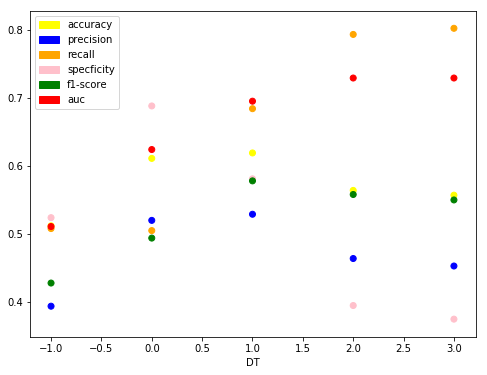

In [27]:
plt.figure(figsize=(8,6))

y = [0.512, 0.394, 0.508, 0.524, 0.428, 0.511]
x = [-1,-1,-1,-1,-1,-1]
plt.scatter(x, y, c=['yellow', 'blue', 'orange', 'pink', 'green', 'red'])

y = [0.611,0.52,0.505,0.688,0.494,0.624]
x = [0,0,0,0,0,0]
plt.scatter(x, y, c=['yellow', 'blue', 'orange', 'pink', 'green', 'red'])

y = [0.619, 0.529,0.684,0.581,0.578,0.695]
x = [1,1,1,1,1,1]
plt.scatter(x, y, c=['yellow', 'blue', 'orange', 'pink', 'green', 'red'])

y = [0.564,0.464,0.793,0.395,0.558,0.729]
x = [2,2,2,2,2,2]
plt.scatter(x, y, c=['yellow', 'blue', 'orange', 'pink', 'green', 'red'])

y = [0.557,0.453,0.802,0.375,0.55,0.729]
x = [3,3,3,3,3,3]
plt.scatter(x, y, c=['yellow', 'blue', 'orange', 'pink', 'green', 'red'])

plt.xlabel('DT')

import matplotlib.patches as mpatches

acc_patch = mpatches.Patch( color='yellow', label='accuracy')
pre_patch = mpatches.Patch( color='blue', label='precision')
rec_patch = mpatches.Patch( color='orange', label='recall')
spe_patch = mpatches.Patch( color='pink', label='specficity')
f1_patch = mpatches.Patch( color='green', label='f1-score')
auc_patch = mpatches.Patch( color='red', label='auc')

plt.legend(handles=[acc_patch, pre_patch, rec_patch, spe_patch, f1_patch, auc_patch], loc='best')

plt.show()

In [ ]:
splits=100
folds = 3
percentages = np.linspace(0.01 , 1, 20)
linspace = np.linspace(10e-4 , 10e-1, num=10)

f=[]
auc=[]
precision=[]
recall=[]
specificity=[]
accuracy=[]

f_s=[]
auc_s=[]
precision_s=[]
recall_s=[]
specificity_s=[]
accuracy_s=[]

f1=[]
auc1=[]
precision1=[]
recall1=[]
specificity1=[]
accuracy1=[]

f1_s=[]
auc1_s=[]
precision1_s=[]
recall1_s=[]
specificity1_s=[]
accuracy1_s=[]


for per in percentages:
    print("percentage:", per)
    F, AUC, PRECISION, RECALL, SPECIFICITY, ACCURACY, Fs, AUCs, PRECISIONs, RECALLs, SPECIFICITYs, ACCURACYs, F1, AUC1, PRECISION1, RECALL1, SPECIFICITY1, ACCURACY1, F1s, AUC1s, PRECISION1s, RECALL1s, SPECIFICITY1s, ACCURACY1s = nested_CV_F_measure(X, y, splits, folds, linspace, dt, per, y_short, sub_id, sub_id_short, zeros)
    f.append(F)
    auc.append(AUC)
    precision.append(PRECISION)
    recall.append(RECALL)
    specificity.append(SPECIFICITY)
    accuracy.append(ACCURACY)
    
    f_s.append(Fs)
    auc_s.append(AUCs)
    precision_s.append(PRECISIONs)
    recall_s.append(RECALLs)
    specificity_s.append(SPECIFICITYs)
    accuracy_s.append(ACCURACYs)
    
    f1.append(F1)
    auc1.append(AUC1)
    precision1.append(PRECISION1)
    recall1.append(RECALL1)
    specificity1.append(SPECIFICITY1)
    accuracy1.append(ACCURACY1)
    
    f1_s.append(F1s)
    auc1_s.append(AUC1s)
    precision1_s.append(PRECISION1s)
    recall1_s.append(RECALL1s)
    specificity1_s.append(SPECIFICITY1s)
    accuracy1_s.append(ACCURACY1s)
    

    
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/f_1_2', f)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/auc_1_2', auc)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/precision_1_2', precision)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/recall_1_2', recall)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/specificity_1_2', specificity)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/accuracy_1_2', accuracy)

np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/f_s_1_2', f_s)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/auc_s_1_2', auc_s)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/precision_s_1_2', precision_s)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/recall_s_1_2', recall_s)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/specificity_s_1_2', specificity_s)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/accuracy_s_1_2', accuracy_s)

np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/f1_1_2', f1)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/auc1_1_2', auc1)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/precision1_1_2', precision1)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/recall1_1_2', recall1)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/specificity1_1_2', specificity1)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/accuracy1_1_2', accuracy1)

np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/f1_s_1_2', f1_s)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/auc1_s_1_2', auc1_s)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/precision1_s_1_2', precision1_s)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/recall1_s_1_2', recall1_s)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/specificity1_s_1_2', specificity1_s)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/accuracy1_s_1_2', accuracy1_s)


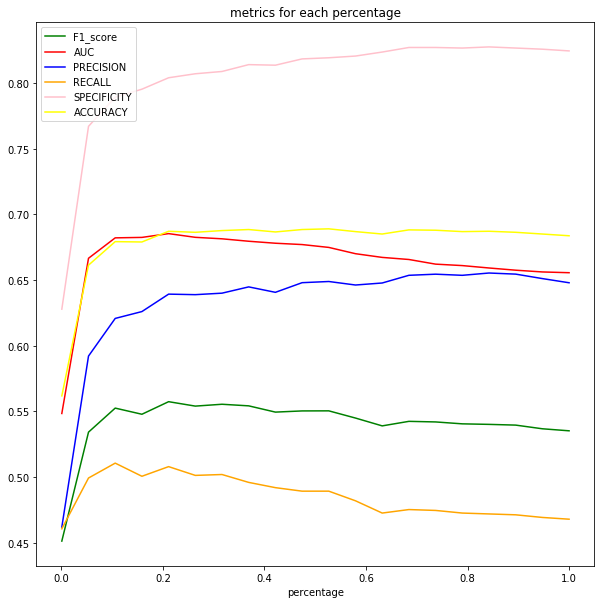

In [29]:
percentages = np.linspace(0.001 , 1, 20)

f1 = np.load('/home/miquel/ForMiquel/CLEAN2/results_definitive/f_2.npy')
auc1 = np.load('/home/miquel/ForMiquel/CLEAN2/results_definitive/auc_2.npy')
precision1 = np.load('/home/miquel/ForMiquel/CLEAN2/results_definitive/precision_2.npy')
recall1 = np.load('/home/miquel/ForMiquel/CLEAN2/results_definitive/recall_2.npy')
specificity1 = np.load('/home/miquel/ForMiquel/CLEAN2/results_definitive/specificity_2.npy')
accuracy1 = np.load('/home/miquel/ForMiquel/CLEAN2/results_definitive/accuracy_2.npy')


plt.figure(figsize=(10,10))
plt.plot(percentages, f1, color='green', label='F1_score')
plt.plot(percentages, auc1, color='red', label='AUC')
plt.plot(percentages, precision1, color='blue', label='PRECISION')
plt.plot(percentages, recall1, color='orange', label='RECALL')
plt.plot(percentages, specificity1, color='pink', label='SPECIFICITY')
plt.plot(percentages, accuracy1, color='yellow', label='ACCURACY')

plt.legend(loc='best')
plt.xlabel('percentage')
plt.title('metrics for each percentage')
plt.show()  

In [15]:
splits = 100
folds= 3
linspace = np.linspace(10e-2, 10e3, num=20)
percentage = 0.35
F, AUC, PRECISION, RECALL, SPECIFICITY, ACCURACY, Fs, AUCs, PRECISIONs, RECALLs, SPECIFICITYs, ACCURACYs, F1, AUC1, PRECISION1, RECALL1, SPECIFICITY1, ACCURACY1, F1s, AUC1s, PRECISION1s, RECALL1s, SPECIFICITY1s, ACCURACY1s = nested_CV_F_measure(X, y, splits, folds, linspace, dt, percentage, y_short, sub_id, sub_id_short, zeros)
os.system('espeak "la ejecución ha terminadoooooooooooooooooooooooooo"')

split: 

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    180 ..., 580922 580925 580926] are constant.
  UserWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


1
jacobians at train: 248
fold: 1
fold: 2
fold: 3
C: 0.1
split: 2
jacobians at train: 220


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   354    426    546 ..., 580917 580918 580919] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 3
jacobians at train: 213


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   295    303    317 ..., 580917 580918 580919] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 4
jacobians at train: 232


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   402    426    451 ..., 580922 580925 580926] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 5
jacobians at train: 223


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   295    303    312 ..., 580895 580896 580897] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 6
jacobians at train: 226


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   151    287    357 ..., 580885 580886 580887] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 1052.72105263
split: 7
jacobians at train: 211


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    85    129    140 ..., 580903 580904 580905] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 8
jacobians at train: 239


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   187    192    193 ..., 580886 580887 580924] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 9
jacobians at train: 238


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   180    181    185 ..., 580913 580914 580915] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 10
jacobians at train: 239


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   334    347    354 ..., 580913 580914 580915] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 11
jacobians at train: 209


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   151    295    303 ..., 580913 580914 580915] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 12
jacobians at train: 215


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   207    402    483 ..., 580922 580925 580926] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 13
jacobians at train: 235


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   334    347    387 ..., 580876 580888 580889] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 14
jacobians at train: 235


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    207 ..., 580922 580925 580926] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 15
jacobians at train: 224


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   295    303    319 ..., 580786 580800 580815] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 16
jacobians at train: 221


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   180    181    185 ..., 580917 580918 580919] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 17
jacobians at train: 250


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    400 ..., 580895 580896 580897] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 18
jacobians at train: 241


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   207    334    347 ..., 580865 580877 580881] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 19
jacobians at train: 231


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   180    181    185 ..., 580786 580800 580815] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 20
jacobians at train: 239


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   177    182    187 ..., 580914 580915 580924] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 21
jacobians at train: 228


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    129 ..., 580917 580918 580919] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 22
jacobians at train: 218


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   334    347    357 ..., 580752 580753 580857] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 23
jacobians at train: 256


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    180 ..., 580903 580904 580905] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 24
jacobians at train: 239


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 580920 580921 580924] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 1579.03157895
split: 25
jacobians at train: 225


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    293 ..., 580876 580888 580889] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 26
jacobians at train: 210


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    237 ..., 580902 580906 580907] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 27
jacobians at train: 241


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   151    287    334 ..., 580902 580906 580907] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 28
jacobians at train: 238


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    357 ..., 580895 580896 580897] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 526.410526316
split: 29
jacobians at train: 227


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    151 ..., 580903 580904 580905] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 30
jacobians at train: 224


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   151    207    357 ..., 580922 580925 580926] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 526.410526316
split: 31
jacobians at train: 240


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   151    187    192 ..., 580924 580925 580926] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 32
jacobians at train: 217


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    237 ..., 580895 580896 580897] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 33
jacobians at train: 233


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    237 ..., 580913 580914 580915] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 34
jacobians at train: 213


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   151    180    181 ..., 580607 580653 580670] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 35
jacobians at train: 230


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    180 ..., 580922 580925 580926] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 36
jacobians at train: 238


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    151 ..., 580857 580865 580877] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 37
jacobians at train: 223


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   151    180    181 ..., 580922 580925 580926] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 38
jacobians at train: 222


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   334    347    415 ..., 580917 580918 580919] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 1579.03157895
split: 39
jacobians at train: 236


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   402    439    547 ..., 580922 580925 580926] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 40
jacobians at train: 237


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   151    402    403 ..., 580751 580752 580753] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 41
jacobians at train: 177


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    237 ..., 580917 580918 580919] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 42
jacobians at train: 223


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   175    176    269 ..., 580913 580914 580915] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 2105.34210526
split: 43
jacobians at train: 235


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    198 ..., 580903 580904 580905] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 44
jacobians at train: 234


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   287    357    358 ..., 580917 580918 580919] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 45
jacobians at train: 238
fold: 1
fold: 2
fold: 3
C: 0.1
split: 46
jacobians at train: 242
fold: 1
fold: 2
fold: 3
C: 0.1
split: 47
jacobians at train: 238


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   187    192    193 ..., 580914 580915 580924] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 48
jacobians at train: 243


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   317    318    334 ..., 580913 580914 580915] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 2105.34210526
split: 49
jacobians at train: 226


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    334 ..., 580917 580918 580919] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 50
jacobians at train: 239
fold: 1
fold: 2
fold: 3
C: 0.1
split: 51
jacobians at train: 217


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   177    182    187 ..., 580846 580857 580924] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 52
jacobians at train: 204


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   151    175    176 ..., 580902 580906 580907] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 1052.72105263
split: 53
jacobians at train: 212


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   151    207    295 ..., 580922 580925 580926] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 54
jacobians at train: 200
fold: 1
fold: 2
fold: 3
C: 0.1
split: 55
jacobians at train: 246


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   177    182    187 ..., 580906 580907 580924] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 56
jacobians at train: 233


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    151 ..., 580895 580896 580897] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 57
jacobians at train: 227


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   287    400    401 ..., 580903 580904 580905] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 58
jacobians at train: 213


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   287    387    482 ..., 580917 580918 580919] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 59
jacobians at train: 237


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   312    313    314 ..., 580913 580914 580915] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 60
jacobians at train: 232


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    237 ..., 580922 580925 580926] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 61
jacobians at train: 232


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   151    180    181 ..., 580913 580914 580915] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 62
jacobians at train: 235
fold: 1
fold: 2
fold: 3
C: 0.1
split: 63
jacobians at train: 238


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   179    187    192 ..., 580914 580915 580924] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 64
jacobians at train: 230


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    179 ..., 580914 580915 580924] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 65
jacobians at train: 237


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   387    400    401 ..., 580565 580865 580877] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 66
jacobians at train: 234
fold: 1
fold: 2
fold: 3
C: 0.1
split: 67
jacobians at train: 246


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    187 ..., 580924 580925 580926] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 68
jacobians at train: 235


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   287    295    303 ..., 580902 580906 580907] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 69
jacobians at train: 233


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    177 ..., 580914 580915 580924] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 70
jacobians at train: 234


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   207    354    402 ..., 580913 580914 580915] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 71
jacobians at train: 247


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   151    180    181 ..., 580917 580918 580919] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 72
jacobians at train: 227


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   151    179    187 ..., 580906 580907 580924] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 73
jacobians at train: 243
fold: 1
fold: 2
fold: 3
C: 0.1
split: 74
jacobians at train: 207


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   354    404    426 ..., 580922 580925 580926] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 75
jacobians at train: 234


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   295    303    312 ..., 580922 580925 580926] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 76
jacobians at train: 231


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   354    482    523 ..., 580922 580925 580926] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 77
jacobians at train: 252


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    177 ..., 580914 580915 580924] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 78
jacobians at train: 232


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   180    181    185 ..., 580920 580921 580924] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 79
jacobians at train: 217
fold: 1
fold: 2
fold: 3
C: 0.1
split: 80
jacobians at train: 228


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   295    303    319 ..., 580815 580831 580881] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 81
jacobians at train: 223
fold: 1
fold: 2
fold: 3
C: 0.1
split: 82
jacobians at train: 203
fold: 1
fold: 2
fold: 3
C: 0.1
split: 83
jacobians at train: 234


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 580902 580906 580907] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 84
jacobians at train: 212


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   293    294    402 ..., 580903 580904 580905] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 85
jacobians at train: 216


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   287    295    296 ..., 580815 580831 580857] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 86
jacobians at train: 198


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   151    175    176 ..., 580885 580886 580887] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 526.410526316
split: 87
jacobians at train: 225


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   180    181    185 ..., 580902 580906 580907] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 88
jacobians at train: 248


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   180    181    185 ..., 580895 580896 580897] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 89
jacobians at train: 236


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    129 ..., 580920 580921 580924] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 90
jacobians at train: 231


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    151 ..., 580922 580925 580926] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 91
jacobians at train: 226
fold: 1
fold: 2
fold: 3
C: 0.1
split: 92
jacobians at train: 241


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   207    357    377 ..., 580902 580906 580907] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 93
jacobians at train: 227


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   180    181    185 ..., 580903 580904 580905] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 94
jacobians at train: 225


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   179    187    192 ..., 580865 580877 580924] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 95
jacobians at train: 204


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   180    181    185 ..., 580905 580906 580907] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 96
jacobians at train: 236


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 580800 580815 580857] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 97
jacobians at train: 210


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    187 ..., 580906 580907 580924] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 526.410526316
split: 98
jacobians at train: 236


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   207    269    354 ..., 580902 580906 580907] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
split: 99
jacobians at train: 235


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    180 ..., 580917 580918 580919] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 4736.89473684
split: 100
jacobians at train: 240


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   187    192    193 ..., 580896 580897 580924] are constant.
  UserWarning)


fold: 1
fold: 2
fold: 3
C: 0.1
ACCURACY_mean: 0.605895927834
PRECISION_mean: 0.507836674358
RECALL_mean: 0.523923624036
SPECIFICITY_mean: 0.664782728442
F_mean: 0.501577790162
AUC_mean: 0.612792311071
ACCURACY1_mean: 0.59949435696
PRECISION1_mean: 0.508616593815
RECALL1_mean: 0.700772774951
SPECIFICITY1_mean: 0.53908315283
F1_mean: 0.572412889405
AUC1_mean: 0.672612727546
ACCURACY_std: 0.0657655953236
PRECISION_std: 0.160272649458
RECALL_std: 0.11654967176
SPECIFICITY_std: 0.114021431522
F_std: 0.114696266063
AUC_std: 0.0871218040559
ACCURACY1_std: 0.106276903542
PRECISION1_std: 0.164958850121
RECALL1_std: 0.14561454141
SPECIFICITY1_std: 0.159894471276
F1_std: 0.135448360546
AUC1_std: 0.123504976242


0

In [24]:
dt

array([ 363,  388,  363,  380,  365,  378,  378,  724,  346,  378,  362,
        720,  358,  355, 1814, 1459,  355, 1814, 1459,  359,  410,  358,
        380, 1701, 2073, 1321, 1693,  372,  364, 1106, 1473, 1826,  742,
       1109, 1462,  367,  720,  353,  383,  363, 1095, 1466, 1826,  732,
       1103, 1463,  371,  731,  360,  397,  367,  368,  362,  720,  358,
        369,  364, 1897, 1533,  371, 1464, 2182, 1093, 1811,  718,  367,
       1094, 1452,  727, 1085,  358,  372, 1094, 1457,  722, 1085,  363,
        381, 1094, 1465, 1850,  713, 1084, 1469,  371,  756,  385,  345,
        364,  728,  364,  368, 1097,  729,  366,  369, 1099, 1460,  730,
       1091,  361,  389,  357,  366,  360,  735,  375,  368, 1120, 1491,
       1932,  752, 1123, 1564,  371,  812,  441,  404,  366, 1524, 1158,
        366, 1107,  741,  366, 1107,  741,  395,  352,  371,  368,  371,
        830, 1156,  459,  785,  326,  388,  783, 1108,  395,  720,  325,
        378,  365,  381,  722, 1578,  341, 1197,  8

In [ ]:
splits = 100
folds = 3
percentages = np.linspace(0.001 , 10, 100)
linspace = np.linspace(10e-3, 10, num=10)

f=[]
auc=[]
precision=[]
recall=[]
specificity=[]

for per in percentages:
    print("percentage:", per)
    F, AUC, PRECISION, RECALL, SPECIFICITY = nested_CV_F_measure(X, y, splits, folds, linspace, dt, per, y_short, sub_id, sub_id_short)
    f.append(F)
    auc.append(AUC)
    precision.append(PRECISION)
    recall.append(RECALL)
    specificity.append(SPECIFICITY)

plt.figure(figsize=(10,10))
plt.plot(percentages, f, color='green', label='F1_score')
plt.plot(percentages, auc, color='red', label='AUC')
plt.plot(percentages, precision, color='blue', label='PRECISION')
plt.plot(percentages, recall, color='orange', label='RECALL')
plt.plot(percentages, specificity, color='pink', label='SPECIFICITY')
plt.legend(loc='best')
plt.xlabel('percentage')
plt.title('metrics for each percentage')
plt.show()  


In [ ]:
np.save('/imatge/martigues/work/CLEAN2/results/f_1', f)
np.save('/imatge/martigues/work/CLEAN2/results/auc_1', auc)
np.save('/imatge/martigues/work/CLEAN2/results/precision_1', precision)
np.save('/imatge/martigues/work/CLEAN2/results/recall_1', recall)
np.save('/imatge/martigues/work/CLEAN2/results/specificity_1', specificity)


## split per jacobian

In [21]:
X=np.load('/home/miquel/ForMiquel/CLEAN2/X_c1_1j_full2.npy') 
y=np.load('/home/miquel/ForMiquel/CLEAN2/y_1j_full2.npy') #subject labels
#sub_id=np.load('/home/miquel/ForMiquel/CLEAN2/sub_id_short.npy') #subject idxs
#jac_idx=np.load('/home/miquel/ForMiquel/CLEAN2/jac_idx_1j_full2.npy')
#dt=np.load('/home/miquel/ForMiquel/CLEAN2/dt_full2.npy')
zeros=np.load('/home/miquel/ForMiquel/CLEAN2/zero_cols_X_full2.npy')
dt=np.load('/home/miquel/ForMiquel/CLEAN2/dt_full2.npy')


#X=np.load('/home/miquel/ForMiquel/CLEAN2/X_c1_1j_1y.npy') 
#y=np.load('/home/miquel/ForMiquel/CLEAN2/y_1j_1y.npy') #subject labels
#jac_idx=np.load('/home/miquel/ForMiquel/CLEAN2/jac_idx_1j_1y.npy')
#zeros=np.load('/home/miquel/ForMiquel/CLEAN2/zero_cols_JB_c1_1j_1y.npy')
np.shape(X)

(124, 572738)

In [22]:
def KFold_intern(X_train, y_train, folds, linspace, dt, percentage):
    
    l=len(linspace)
    l2=X_train.shape[0]
    TP=np.zeros((l))
    FP=np.zeros((l))
    FN=np.zeros((l))
    
    dt=np.reshape(dt, (len(dt),1))
    
    kf = cross_validation.KFold(l2, n_folds=folds)
       
    for train_index_f, test_index_f in kf:  
        X_train_f = X_train[train_index_f,:]
        X_test_f = X_train[test_index_f,:]
        y_train_f = y_train[train_index_f]
        y_test_f = y_train[test_index_f]
     
        tp_l=[]
        fp_l=[]
        fn_l=[]
        
        for c in linspace:
            
            y_test_f = y[test_index_f]
            dt_test_f = dt[test_index_f]
            
            clf = LogisticRegression(solver='liblinear', penalty='l2', C=c, class_weight=None)
            clf.fit(X_train_f, y_train_f)
            pred = clf.predict(X_test_f)
            conf = confusion_matrix(y_test_f, pred)
            
            #mask0 = np.where(dt_test_f>1.09)#~400 days
            #mask0 = np.asarray(mask0)
            #pred = pred[mask0][0]
            #y_test_f = y_test_f[mask0][0]
            conf = confusion_matrix(y_test_f, pred)
            tp_l.append(conf[1,1])
            fp_l.append(conf[0,1])
            fn_l.append(conf[1,0])
            
            
        TP = np.vstack((TP, tp_l))
        FP = np.vstack((FP, fp_l))
        FN = np.vstack((FN, fn_l))
        
            
    TP=TP[1:,:]
    FP=FP[1:,:]
    FN=FN[1:,:]
    
    TP=np.sum(TP, axis=0)
    FP=np.sum(FP, axis=0)
    FN=np.sum(FN, axis=0)
    
    F=(2*TP)/(2*TP + FP + FN)
    maxi = np.amax(F)
    maxi_idx = np.argmax(F)
    
    #plt.figure(1)
    #plt.plot(linspace, F, color='blue', label='F-measure')
    #plt.legend(loc='best')
    #plt.xlabel('C')
    #plt.title('metrics logistic regression combination c1 and c2')
    #plt.show()
    
    return maxi, maxi_idx

In [26]:
def nested_CV_F_measure(X, y, splits, folds, linspace, dt, percentage, zeros):
   
    
    box = np.zeros((121,145,121))

    SPECIFICITY=[]
    PRECISION=[]
    RECALL=[]
    AUC=[]
    F=[]
    ACCURACY=[]
    
    SPECIFICITY1=[]
    PRECISION1=[]
    RECALL1=[]
    AUC1=[]
    F1=[]
    ACCURACY1=[]
    
    tp_l=[]
    fp_l=[]
    fn_l=[]
    
    spl = StratifiedShuffleSplit(n_splits=splits, test_size=0.2, random_state=42)
    split=1
    
    for train_index, test_index in spl.split(X, y):
        X_train = X[train_index,:]
        y_train = y[train_index]
        X_test = X[test_index,:]
        y_test = y[test_index]
        dt_test = dt[test_index]
        dt_train = dt[train_index]
        print("split:", split)
        split = split + 1
        
        #remove train jac. with dt < 415 days
        #mask = np.where(dt_train>1.14)#~400 days
        #mask = np.asarray(mask)
        #X_train = X_train[mask,:][0]
        #y_train = y_train[mask][0]
        
        S = SelectPercentile(percentile=percentage)
        S.fit(X_train, y_train)
        
        X_train_s = X_train[:,S.get_support()]
        X_test_s = X_test[:,S.get_support()]
     
        maxi, maxi_idx = KFold_intern(X_train_s, y_train, folds, linspace, dt_train, percentage)
        c = linspace[maxi_idx]
        #print("c:", c)
        
        clf = LogisticRegression(solver='liblinear', penalty='l2', C=c, class_weight='balanced')
        clf.fit(X_train_s, y_train)
        pred = clf.predict(X_test_s)
        probas_ = clf.predict_proba(X_test_s)
        

        probas_ = probas_[:, 1]        
        
        #preparation masks to test AUC as function of dt
        mask1 = np.where(dt_test>1.15)#~400 days
        mask1 = np.asarray(mask1)
        pred_1 = pred[mask1][0]
        y_test_1 = y_test[mask1][0]
        probas_1 = probas_[mask1][0]
        
        conf = confusion_matrix(y_test, pred)
        tp_l.append(conf[1,1])
        fp_l.append(conf[0,1])
        fn_l.append(conf[1,0])
        
        f1=f1_score(y_test, pred)
        F.append(f1)
        
        f1_1=f1_score(y_test_1, pred_1)
        if np.isnan(f1_1) == False:
            F1.append(f1_1)
        
        
        fpr, tpr, thresholds = roc_curve(y_test, probas_)
        roc_auc = sklearn.metrics.auc(fpr, tpr)
        AUC.append(roc_auc)
        
        fpr, tpr, thresholds = roc_curve(y_test_1, probas_1)
        roc_auc_1 = sklearn.metrics.auc(fpr, tpr)
        if np.isnan(roc_auc_1) == False:
            AUC1.append(roc_auc_1)

        
        precision=precision_score(y_test, pred)
        recall=recall_score(y_test, pred)
        PRECISION.append(precision)
        RECALL.append(recall)
        specificity= (conf[0,0])/(conf[0,0]+conf[0,1])
        SPECIFICITY.append(specificity)
        acc=accuracy_score(y_test, pred)
        ACCURACY.append(acc)
        
        precision1=precision_score(y_test_1, pred_1)
        recall1=recall_score(y_test_1, pred_1)
        PRECISION1.append(precision1)
        RECALL1.append(recall1)
        conf1 = confusion_matrix(y_test_1, pred_1)
        specificity1= (conf1[0,0])/(conf1[0,0]+conf1[0,1])
        SPECIFICITY1.append(specificity1)
        acc1=accuracy_score(y_test_1, pred_1)
        ACCURACY1.append(acc1)
        
    
        aux = np.zeros((121*145*121))
        aux[~zeros] = np.asarray(S.get_support())
        aux = np.reshape(aux, (121,145,121))
        box = box + aux
    
    box = np.transpose(box)
    #np.save('/home/miquel/ForMiquel/CLEAN2/Voxel_appareances_jacobian_' + str(splits) + '_' + str(percentage) + '_2y', box)
    new_img = nib.Nifti1Image(box, np.eye(4))
    #nib.save(new_img, 'img_Voxel_appareances_jacobian_' + str(splits) + '_' + str(percentage) + '_2y.nii.gz')
    
    
    TP=np.sum(tp_l, axis=0)
    FP=np.sum(fp_l, axis=0)
    FN=np.sum(fn_l, axis=0)

    
    F_g=(2*TP)/(2*TP + FP + FN)
    

    print("ACCURACY_mean:", np.mean(ACCURACY))
    print("PRECISION_mean:", np.mean(PRECISION))
    print("RECALL_mean:", np.mean(RECALL))
    print("SPECIFICITY_mean:", np.mean(SPECIFICITY))
    print("F_mean:", np.mean(F))
    print("AUC_mean:", np.mean(AUC))
    
    print("ACCURACY1_mean:", np.mean(ACCURACY1))
    print("PRECISION1_mean:", np.mean(PRECISION1))
    print("RECALL1_mean:", np.mean(RECALL1))
    print("SPECIFICITY1_mean:", np.mean(SPECIFICITY1))
    print("F1_mean:", np.mean(F1))
    print("AUC1_mean:", np.mean(AUC1))

    print("ACCURACY_std:", np.std(ACCURACY))
    print("PRECISION_std:", np.std(PRECISION))
    print("RECALL_std:", np.std(RECALL))
    print("SPECIFICITY_std:", np.std(SPECIFICITY))
    print("F_std:", np.std(F))
    print("AUC_std:", np.std(AUC))

    print("ACCURACY1_std:", np.std(ACCURACY1))
    print("PRECISION1_std:", np.std(PRECISION1))
    print("RECALL1_std:", np.std(RECALL1))
    print("SPECIFICITY1_std:", np.std(SPECIFICITY1))
    print("F1_std:", np.std(F1))
    print("AUC1_std:", np.std(AUC1))

    return np.mean(F), np.mean(AUC), np.mean(PRECISION), np.mean(RECALL), np.mean(SPECIFICITY), np.mean(ACCURACY), np.std(F), np.std(AUC), np.std(PRECISION), np.std(RECALL), np.std(SPECIFICITY), np.std(ACCURACY),np.mean(F1), np.mean(AUC1), np.mean(PRECISION1), np.mean(RECALL1), np.mean(SPECIFICITY1), np.mean(ACCURACY1), np.std(F1), np.std(AUC1), np.std(PRECISION1), np.std(RECALL1), np.std(SPECIFICITY1), np.std(ACCURACY1)


In [28]:
splits = 100
folds= 3
linspace = np.linspace(10e-3, 10e3, num=20)
percentage = 1
F, AUC, PRECISION, RECALL, SPECIFICITY, ACCURACY, Fs, AUCs, PRECISIONs, RECALLs, SPECIFICITYs, ACCURACYs, F1, AUC1, PRECISION1, RECALL1, SPECIFICITY1, ACCURACY1, F1s, AUC1s, PRECISION1s, RECALL1s, SPECIFICITY1s, ACCURACY1s = nested_CV_F_measure(X, y, splits, folds, linspace, dt, percentage, zeros)
os.system('espeak "la ejecución ha terminadoooooooooooooooooooooooooo"')

split: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572733 572736 572737] are constant.
  UserWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


split: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572720 572721 572722] are constant.
  UserWarning)


split: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572712 572713 572714] are constant.
  UserWarning)


split: 4


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    288 ..., 572733 572736 572737] are constant.
  UserWarning)


split: 5


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    305 ..., 572720 572721 572722] are constant.
  UserWarning)


split: 6


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572712 572713 572714] are constant.
  UserWarning)


split: 7


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572712 572713 572714] are constant.
  UserWarning)


split: 8


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    177 ..., 572731 572732 572735] are constant.
  UserWarning)


split: 9


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572728 572729 572730] are constant.
  UserWarning)


split: 10


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    324 ..., 572728 572729 572730] are constant.
  UserWarning)


split: 11


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572728 572729 572730] are constant.
  UserWarning)


split: 12


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572733 572736 572737] are constant.
  UserWarning)


split: 13


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    324 ..., 572692 572702 572703] are constant.
  UserWarning)


split: 14


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572733 572736 572737] are constant.
  UserWarning)


split: 15


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572554 572621 572634] are constant.
  UserWarning)


split: 16


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572712 572713 572714] are constant.
  UserWarning)


split: 17


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    288 ..., 572720 572721 572722] are constant.
  UserWarning)


split: 18


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572704 572708 572709] are constant.
  UserWarning)


split: 19


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572605 572621 572634] are constant.
  UserWarning)


split: 20


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572731 572732 572735] are constant.
  UserWarning)


split: 21


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572712 572713 572714] are constant.
  UserWarning)


split: 22


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    324 ..., 572595 572596 572685] are constant.
  UserWarning)


split: 23


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572704 572708 572709] are constant.
  UserWarning)


split: 24


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572731 572732 572735] are constant.
  UserWarning)


split: 25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    288 ..., 572692 572702 572703] are constant.
  UserWarning)


split: 26


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    264 ..., 572703 572708 572709] are constant.
  UserWarning)


split: 27


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572472 572684 572704] are constant.
  UserWarning)


split: 28


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572720 572721 572722] are constant.
  UserWarning)


split: 29


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572553 572576 572685] are constant.
  UserWarning)


split: 30


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572733 572736 572737] are constant.
  UserWarning)


split: 31


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572735 572736 572737] are constant.
  UserWarning)


split: 32


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    282 ..., 572720 572721 572722] are constant.
  UserWarning)


split: 33


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    388 ..., 572728 572729 572730] are constant.
  UserWarning)


split: 34


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572461 572604 572605] are constant.
  UserWarning)


split: 35
split: 36


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572605 572685 572704] are constant.
  UserWarning)


split: 37
split: 38


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    324 ..., 572509 572510 572528] are constant.
  UserWarning)


split: 39


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    388 ..., 572733 572736 572737] are constant.
  UserWarning)


split: 40


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572596 572708 572709] are constant.
  UserWarning)


split: 41


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    388 ..., 572685 572708 572709] are constant.
  UserWarning)


split: 42
split: 43


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572685 572708 572709] are constant.
  UserWarning)


split: 44


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    282 ..., 572594 572595 572596] are constant.
  UserWarning)


split: 45
split: 46
split: 47
split: 48
split: 49


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    324 ..., 572596 572670 572685] are constant.
  UserWarning)


split: 50
split: 51


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    175 ..., 572731 572732 572735] are constant.
  UserWarning)


split: 52


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572692 572702 572703] are constant.
  UserWarning)


split: 53
split: 54


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    324 ..., 572621 572634 572685] are constant.
  UserWarning)


split: 55


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572731 572732 572735] are constant.
  UserWarning)


split: 56


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572720 572721 572722] are constant.
  UserWarning)


split: 57


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    282 ..., 572712 572713 572714] are constant.
  UserWarning)


split: 58


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    282 ..., 572728 572729 572730] are constant.
  UserWarning)


split: 59
split: 60


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572733 572736 572737] are constant.
  UserWarning)


split: 61


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572728 572729 572730] are constant.
  UserWarning)


split: 62
split: 63
split: 64
split: 65


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    386 ..., 572407 572421 572704] are constant.
  UserWarning)


split: 66


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    288 ..., 572728 572729 572730] are constant.
  UserWarning)


split: 67


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    177 ..., 572735 572736 572737] are constant.
  UserWarning)


split: 68


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    282 ..., 572621 572634 572685] are constant.
  UserWarning)


split: 69
split: 70


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572728 572729 572730] are constant.
  UserWarning)


split: 71


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572596 572685 572704] are constant.
  UserWarning)


split: 72
split: 73


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    324 ..., 572712 572713 572714] are constant.
  UserWarning)


split: 74
split: 75


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    305 ..., 572733 572736 572737] are constant.
  UserWarning)


split: 76


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572733 572736 572737] are constant.
  UserWarning)


split: 77
split: 78
split: 79
split: 80


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    388 ..., 572677 572708 572709] are constant.
  UserWarning)


split: 81


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572728 572729 572730] are constant.
  UserWarning)


split: 82
split: 83
split: 84


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    288 ..., 572685 572708 572709] are constant.
  UserWarning)


split: 85


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572662 572677 572685] are constant.
  UserWarning)


split: 86
split: 87
split: 88


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572720 572721 572722] are constant.
  UserWarning)


split: 89
split: 90
split: 91


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    282 ..., 572733 572736 572737] are constant.
  UserWarning)


split: 92


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572720 572721 572722] are constant.
  UserWarning)


split: 93
split: 94
split: 95


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572712 572713 572714] are constant.
  UserWarning)


split: 96


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572621 572634 572685] are constant.
  UserWarning)


split: 97
split: 98


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572702 572703 572704] are constant.
  UserWarning)


split: 99
split: 100
ACCURACY_mean: 0.6492
PRECISION_mean: 0.588114413364
RECALL_mean: 0.482
SPECIFICITY_mean: 0.760666666667
F_mean: 0.518813094333
AUC_mean: 0.6444
ACCURACY1_mean: 0.676580180612
PRECISION1_mean: 0.610827561328
RECALL1_mean: 0.652095238095
SPECIFICITY1_mean: 0.698110805861
F1_mean: 0.616966726084
AUC1_mean: 0.748474879386
ACCURACY_std: 0.0750157316834
PRECISION_std: 0.13121436757
RECALL_std: 0.126791166885
SPECIFICITY_std: 0.107948547414
F_std: 0.109762672717
AUC_std: 0.0891950172998
ACCURACY1_std: 0.111936731312
PRECISION1_std: 0.160554094911
RECALL1_std: 0.183313010624
SPECIFICITY1_std: 0.140544551873
F1_std: 0.143194292156
AUC1_std: 0.129146906146


0

In [6]:
splits = 100
folds = 3
percentages = np.linspace(0.001 , 0.7, 20)
linspace = np.linspace(10e-3, 10, num=10)

f=[]
auc=[]
precision=[]
recall=[]
specificity=[]
accuracy=[]

f_s=[]
auc_s=[]
precision_s=[]
recall_s=[]
specificity_s=[]
accuracy_s=[]

f1=[]
auc1=[]
precision1=[]
recall1=[]
specificity1=[]
accuracy1=[]

f1_s=[]
auc1_s=[]
precision1_s=[]
recall1_s=[]
specificity1_s=[]
accuracy1_s=[]


for per in percentages:
    print("percentage:", per)
    F, AUC, PRECISION, RECALL, SPECIFICITY, ACCURACY, Fs, AUCs, PRECISIONs, RECALLs, SPECIFICITYs, ACCURACYs, F1, AUC1, PRECISION1, RECALL1, SPECIFICITY1, ACCURACY1, F1s, AUC1s, PRECISION1s, RECALL1s, SPECIFICITY1s, ACCURACY1s = nested_CV_F_measure(X, y, splits, folds, linspace, dt, per, zeros)
    f.append(F)
    auc.append(AUC)
    precision.append(PRECISION)
    recall.append(RECALL)
    specificity.append(SPECIFICITY)
    accuracy.append(ACCURACY)
    
    f_s.append(Fs)
    auc_s.append(AUCs)
    precision_s.append(PRECISIONs)
    recall_s.append(RECALLs)
    specificity_s.append(SPECIFICITYs)
    accuracy_s.append(ACCURACYs)
    
    f1.append(F1)
    auc1.append(AUC1)
    precision1.append(PRECISION1)
    recall1.append(RECALL1)
    specificity1.append(SPECIFICITY1)
    accuracy1.append(ACCURACY1)
    
    f1_s.append(F1s)
    auc1_s.append(AUC1s)
    precision1_s.append(PRECISION1s)
    recall1_s.append(RECALL1s)
    specificity1_s.append(SPECIFICITY1s)
    accuracy1_s.append(ACCURACY1s)
    

    
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/f_1', f)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/auc_1', auc)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/precision_1', precision)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/recall_1', recall)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/specificity_1', specificity)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/accuracy_1', accuracy)

np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/f_s_1', f_s)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/auc_s_1', auc_s)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/precision_s_1', precision_s)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/recall_s_1', recall_s)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/specificity_s_1', specificity_s)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/accuracy_s_1', accuracy_s)

np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/f1_1', f1)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/auc1_1', auc1)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/precision1_1', precision1)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/recall1_1', recall1)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/specificity1_1', specificity1)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/accuracy1_1', accuracy1)

np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/f1_s_1', f1_s)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/auc1_s_1', auc1_s)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/precision1_s_1', precision1_s)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/recall1_s_1', recall1_s)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/specificity1_s_1', specificity1_s)
np.save('/home/miquel/ForMiquel/CLEAN2/results_definitive/accuracy1_s_1', accuracy1_s)



percentage: 0.001
split: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572733 572736 572737] are constant.
  UserWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


split: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572720 572721 572722] are constant.
  UserWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.4/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


split: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572712 572713 572714] are constant.
  UserWarning)


split: 4


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    288 ..., 572733 572736 572737] are constant.
  UserWarning)


split: 5


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    305 ..., 572720 572721 572722] are constant.
  UserWarning)


split: 6


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572712 572713 572714] are constant.
  UserWarning)


split: 7


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572712 572713 572714] are constant.
  UserWarning)


split: 8


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    177 ..., 572731 572732 572735] are constant.
  UserWarning)


split: 9


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572728 572729 572730] are constant.
  UserWarning)


split: 10


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    324 ..., 572728 572729 572730] are constant.
  UserWarning)


split: 11


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572728 572729 572730] are constant.
  UserWarning)


split: 12


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572733 572736 572737] are constant.
  UserWarning)


split: 13


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    324 ..., 572692 572702 572703] are constant.
  UserWarning)


split: 14


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572733 572736 572737] are constant.
  UserWarning)


split: 15


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572554 572621 572634] are constant.
  UserWarning)


split: 16


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572712 572713 572714] are constant.
  UserWarning)


split: 17


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    288 ..., 572720 572721 572722] are constant.
  UserWarning)


split: 18


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572704 572708 572709] are constant.
  UserWarning)


split: 19


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572605 572621 572634] are constant.
  UserWarning)


split: 20


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572731 572732 572735] are constant.
  UserWarning)


split: 21


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572712 572713 572714] are constant.
  UserWarning)


split: 22


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    324 ..., 572595 572596 572685] are constant.
  UserWarning)


split: 23


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572704 572708 572709] are constant.
  UserWarning)


split: 24


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572731 572732 572735] are constant.
  UserWarning)


split: 25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    288 ..., 572692 572702 572703] are constant.
  UserWarning)


split: 26


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    264 ..., 572703 572708 572709] are constant.
  UserWarning)


split: 27


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572472 572684 572704] are constant.
  UserWarning)


split: 28


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572720 572721 572722] are constant.
  UserWarning)


split: 29


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572553 572576 572685] are constant.
  UserWarning)


split: 30


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572733 572736 572737] are constant.
  UserWarning)


split: 31


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572735 572736 572737] are constant.
  UserWarning)


split: 32


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    282 ..., 572720 572721 572722] are constant.
  UserWarning)


split: 33


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    388 ..., 572728 572729 572730] are constant.
  UserWarning)


split: 34


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572461 572604 572605] are constant.
  UserWarning)


split: 35
split: 36


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572605 572685 572704] are constant.
  UserWarning)


split: 37
split: 38


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    324 ..., 572509 572510 572528] are constant.
  UserWarning)


split: 39


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    388 ..., 572733 572736 572737] are constant.
  UserWarning)


split: 40


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572596 572708 572709] are constant.
  UserWarning)


split: 41


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    388 ..., 572685 572708 572709] are constant.
  UserWarning)


split: 42
split: 43


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572685 572708 572709] are constant.
  UserWarning)


split: 44


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    282 ..., 572594 572595 572596] are constant.
  UserWarning)


split: 45
split: 46
split: 47
split: 48
split: 49


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    324 ..., 572596 572670 572685] are constant.
  UserWarning)


split: 50
split: 51


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    175 ..., 572731 572732 572735] are constant.
  UserWarning)


split: 52


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572692 572702 572703] are constant.
  UserWarning)


split: 53
split: 54


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    324 ..., 572621 572634 572685] are constant.
  UserWarning)


split: 55


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572731 572732 572735] are constant.
  UserWarning)


split: 56


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572720 572721 572722] are constant.
  UserWarning)


split: 57


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    282 ..., 572712 572713 572714] are constant.
  UserWarning)


split: 58


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    282 ..., 572728 572729 572730] are constant.
  UserWarning)


split: 59
split: 60


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572733 572736 572737] are constant.
  UserWarning)


split: 61


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572728 572729 572730] are constant.
  UserWarning)


split: 62
split: 63
split: 64
split: 65


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    386 ..., 572407 572421 572704] are constant.
  UserWarning)


split: 66


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    288 ..., 572728 572729 572730] are constant.
  UserWarning)


split: 67


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    177 ..., 572735 572736 572737] are constant.
  UserWarning)


split: 68


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    282 ..., 572621 572634 572685] are constant.
  UserWarning)


split: 69
split: 70


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572728 572729 572730] are constant.
  UserWarning)


split: 71


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572596 572685 572704] are constant.
  UserWarning)


split: 72
split: 73


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    324 ..., 572712 572713 572714] are constant.
  UserWarning)


split: 74
split: 75


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    305 ..., 572733 572736 572737] are constant.
  UserWarning)


split: 76


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572733 572736 572737] are constant.
  UserWarning)


split: 77
split: 78
split: 79
split: 80


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    388 ..., 572677 572708 572709] are constant.
  UserWarning)


split: 81


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572728 572729 572730] are constant.
  UserWarning)


split: 82
split: 83
split: 84


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    288 ..., 572685 572708 572709] are constant.
  UserWarning)


split: 85


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572662 572677 572685] are constant.
  UserWarning)


split: 86
split: 87
split: 88


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572720 572721 572722] are constant.
  UserWarning)


split: 89
split: 90
split: 91


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    282 ..., 572733 572736 572737] are constant.
  UserWarning)


split: 92


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    204 ..., 572720 572721 572722] are constant.
  UserWarning)


split: 93
split: 94
split: 95


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572712 572713 572714] are constant.
  UserWarning)


split: 96


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572621 572634 572685] are constant.
  UserWarning)


split: 97
split: 98


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572702 572703 572704] are constant.
  UserWarning)


split: 99
split: 100
ACCURACY_mean: 0.5736
PRECISION_mean: 0.516035627427
RECALL_mean: 0.539
SPECIFICITY_mean: 0.596666666667
F_mean: 0.48265576541
AUC_mean: 0.584133333333
ACCURACY1_mean: 0.603660688426
PRECISION1_mean: 0.563172046907
RECALL1_mean: 0.637111111111
SPECIFICITY1_mean: 0.605153790654
F1_mean: 0.542080863495
AUC1_mean: 0.656767483046
ACCURACY_std: 0.0950317841567
PRECISION_std: 0.188163563204
RECALL_std: 0.219952267549
SPECIFICITY_std: 0.223383079037
F_std: 0.135925637719
AUC_std: 0.103080464794
ACCURACY1_std: 0.11779415551
PRECISION1_std: 0.212967067462
RECALL1_std: 0.264672053527
SPECIFICITY1_std: 0.246800959815
F1_std: 0.16677957986
AUC1_std: 0.161118658173
percentage: 0.0377894736842
split: 1
split: 2
split: 3
split: 4
split: 5
split: 6
split: 7
split: 8
split: 9
split: 10
split: 11
split: 12
split: 13
split: 14
split: 15
split: 16
split: 17
split: 18
split: 19
split: 20
split: 21
split: 22
split: 23
split: 24
split: 25
split: 26
split: 27
split: 28
split: 29
split: 30

split: 78
split: 79
split: 80
split: 81
split: 82
split: 83
split: 84
split: 85
split: 86
split: 87
split: 88
split: 89
split: 90
split: 91
split: 92
split: 93
split: 94
split: 95
split: 96
split: 97
split: 98
split: 99
split: 100
ACCURACY_mean: 0.6788
PRECISION_mean: 0.638945387945
RECALL_mean: 0.518
SPECIFICITY_mean: 0.786
F_mean: 0.556670177798
AUC_mean: 0.654533333333
ACCURACY1_mean: 0.711554279269
PRECISION1_mean: 0.657136724387
RECALL1_mean: 0.716865079365
SPECIFICITY1_mean: 0.712066711067
F1_mean: 0.667772974274
AUC1_mean: 0.768843275772
ACCURACY_std: 0.0723226105724
PRECISION_std: 0.138259573991
RECALL_std: 0.141689802032
SPECIFICITY_std: 0.107618668352
F_std: 0.109678181662
AUC_std: 0.0950713416335
ACCURACY1_std: 0.109925875528
PRECISION1_std: 0.162295739982
RECALL1_std: 0.176706144244
SPECIFICITY1_std: 0.149987815504
F1_std: 0.133773020627
AUC1_std: 0.11862067316
percentage: 0.221736842105
split: 1
split: 2
split: 3
split: 4
split: 5
split: 6
split: 7
split: 8
split: 9
split:

split: 59
split: 60
split: 61
split: 62
split: 63
split: 64
split: 65
split: 66
split: 67
split: 68
split: 69
split: 70
split: 71
split: 72
split: 73
split: 74
split: 75
split: 76
split: 77
split: 78
split: 79
split: 80
split: 81
split: 82
split: 83
split: 84
split: 85
split: 86
split: 87
split: 88
split: 89
split: 90
split: 91
split: 92
split: 93
split: 94
split: 95
split: 96
split: 97
split: 98
split: 99
split: 100
ACCURACY_mean: 0.6756
PRECISION_mean: 0.628567404817
RECALL_mean: 0.516
SPECIFICITY_mean: 0.782
F_mean: 0.553806275588
AUC_mean: 0.648733333333
ACCURACY1_mean: 0.715186515883
PRECISION1_mean: 0.653596320346
RECALL1_mean: 0.721079365079
SPECIFICITY1_mean: 0.71470956821
F1_mean: 0.671631256514
AUC1_mean: 0.768142615321
ACCURACY_std: 0.0748106944227
PRECISION_std: 0.132179972207
RECALL_std: 0.139799856938
SPECIFICITY_std: 0.10618851162
F_std: 0.112334190189
AUC_std: 0.0940151051693
ACCURACY1_std: 0.107761535537
PRECISION1_std: 0.163788264765
RECALL1_std: 0.17151672557
SPECIFI

split: 42
split: 43
split: 44
split: 45
split: 46
split: 47
split: 48
split: 49
split: 50
split: 51
split: 52
split: 53
split: 54
split: 55
split: 56
split: 57
split: 58
split: 59
split: 60
split: 61
split: 62
split: 63
split: 64
split: 65
split: 66
split: 67
split: 68
split: 69
split: 70
split: 71
split: 72
split: 73
split: 74
split: 75
split: 76
split: 77
split: 78
split: 79
split: 80
split: 81
split: 82
split: 83
split: 84
split: 85
split: 86
split: 87
split: 88
split: 89
split: 90
split: 91
split: 92
split: 93
split: 94
split: 95
split: 96
split: 97
split: 98
split: 99
split: 100
ACCURACY_mean: 0.6744
PRECISION_mean: 0.627511904762
RECALL_mean: 0.514
SPECIFICITY_mean: 0.781333333333
F_mean: 0.552273600668
AUC_mean: 0.644266666667
ACCURACY1_mean: 0.717161443304
PRECISION1_mean: 0.663334054834
RECALL1_mean: 0.712753968254
SPECIFICITY1_mean: 0.724991785992
F1_mean: 0.671511859314
AUC1_mean: 0.76889212408
ACCURACY_std: 0.0744086016533
PRECISION_std: 0.132119204324
RECALL_std: 0.1371276

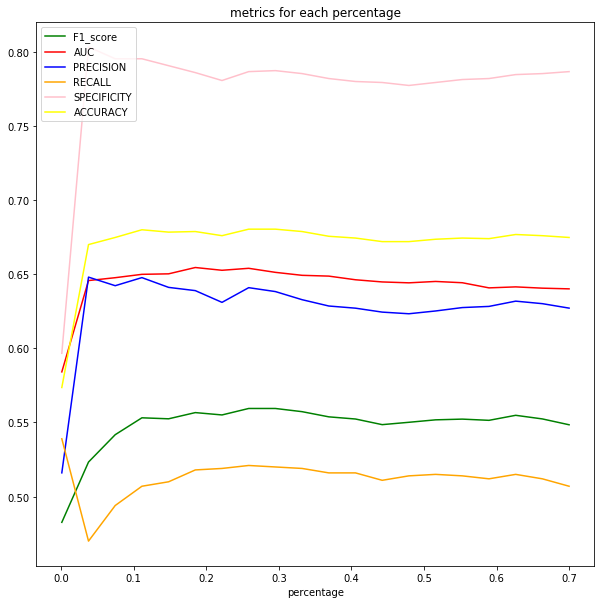

In [8]:
percentages = np.linspace(0.001 , 0.7, 20)

auc = np.load('/home/miquel/ForMiquel/CLEAN2/results_definitive/auc_1.npy')
accuracy = np.load('/home/miquel/ForMiquel/CLEAN2/results_definitive/accuracy_1.npy')
precision = np.load('/home/miquel/ForMiquel/CLEAN2/results_definitive/precision_1.npy')
recall = np.load('/home/miquel/ForMiquel/CLEAN2/results_definitive/recall_1.npy')
f = np.load('/home/miquel/ForMiquel/CLEAN2/results_definitive/f_1.npy')
specificity = np.load('/home/miquel/ForMiquel/CLEAN2/results_definitive/specificity_1.npy')

plt.figure(figsize=(10,10))
plt.plot(percentages, f, color='green', label='F1_score')
plt.plot(percentages, auc, color='red', label='AUC')
plt.plot(percentages, precision, color='blue', label='PRECISION')
plt.plot(percentages, recall, color='orange', label='RECALL')
plt.plot(percentages, specificity, color='pink', label='SPECIFICITY')
plt.plot(percentages, accuracy, color='yellow', label='ACCURACY')

plt.legend(loc='best')
plt.xlabel('percentage')
plt.title('metrics for each percentage')
plt.show()  

In [18]:
X=np.load('/home/miquel/ForMiquel/CLEAN2/X_c1_1j_full2.npy') 
y=np.load('/home/miquel/ForMiquel/CLEAN2/y_1j_full2.npy') #subject labels
#sub_id=np.load('/home/miquel/ForMiquel/CLEAN2/sub_id_short.npy') #subject idxs
#jac_idx=np.load('/home/miquel/ForMiquel/CLEAN2/jac_idx_1j_full2.npy')
dt=np.load('/home/miquel/ForMiquel/CLEAN2/dt_full2.npy')
zeros=np.load('/home/miquel/ForMiquel/CLEAN2/zero_cols_X_full2.npy')


#X=np.load('/imatge/martigues/work/X_c1_1j_1y.npy') 
#y=np.load('/imatge/martigues/work/CLEAN2/y_1j_1y.npy') #subject labels
#sub_id=np.load('/imatge/martigues/work/CLEAN2/sub_idx_1j_1y.npy') #subject idxs
#jac_idx=np.load('/imatge/martigues/work/CLEAN2/jac_idx_1j_1y.npy')

In [20]:
def CV_F_measure(X, y, dt, splits, c, percentage, zeros):
   
    
    box = np.zeros((121,145,121))

    SPECIFICITY=[]
    PRECISION=[]
    RECALL=[]
    AUC=[]
    AUC1=[]
    F=[]
    F1=[]
    ACCURACY=[]
    tp_l=[]
    fp_l=[]
    fn_l=[]
    
    spl = StratifiedShuffleSplit(n_splits=splits, test_size=0.3, random_state=42)
    split=1
    
    for train_index, test_index in spl.split(X, y):
        X_train = X[train_index,:]
        y_train = y[train_index]
        X_test = X[test_index,:]
        y_test = y[test_index]
        dt_train = dt[train_index]
        dt_test = dt[test_index]
        
        mask = np.where(dt_train>1.09)#~400 days
        mask = np.asarray(mask)
        X_train = X_train[mask,:][0]
        y_train = y_train[mask][0]
        
        print('shape X_train:', np.shape(X_train))
        
        print("split:", split)
        split = split + 1
        
        S = SelectPercentile(percentile=percentage)
        S.fit(X_train, y_train)
        
        X_train_s = X_train[:,S.get_support()]
        X_test_s = X_test[:,S.get_support()]

        #clf = SVC(penalty='l1', kernel='linear', probability = True, C=c, class_weight='balanced')
        clf = LogisticRegression(solver='liblinear', probability = True, penalty='l1', C=c, class_weight='balanced')
        clf.fit(X_train_s, y_train)
        pred = clf.predict(X_test_s)
        probas_ = clf.predict_proba(X_test_s)
        probas_ = probas_[:, 1]        

        
        
        #preparation masks to test AUC as function of dt
        mask1 = np.where(dt_test>1.09)#~400 days
        mask1 = np.asarray(mask1)
        pred_1 = pred[mask1][0]
        y_test_1 = y_test[mask1][0]
        probas_1 = probas_[mask1][0]
        
        conf = confusion_matrix(y_test, pred)
        tp_l.append(conf[1,1])
        fp_l.append(conf[0,1])
        fn_l.append(conf[1,0])
        
        f1=f1_score(y_test, pred)
        F.append(f1)
        
        f1_1=f1_score(y_test_1, pred_1)
        if np.isnan(f1_1) == False:
            F1.append(f1_1)
        
        
        fpr, tpr, thresholds = roc_curve(y_test, probas_)
        roc_auc = sklearn.metrics.auc(fpr, tpr)
        AUC.append(roc_auc)
        
        fpr, tpr, thresholds = roc_curve(y_test_1, probas_1)
        roc_auc_1 = sklearn.metrics.auc(fpr, tpr)
        if np.isnan(roc_auc_1) == False:
            AUC1.append(roc_auc_1)

        
        precision=precision_score(y_test, pred)
        recall=recall_score(y_test, pred)
        PRECISION.append(precision)
        RECALL.append(recall)
        specificity= (conf[0,0])/(conf[0,0]+conf[0,1])
        SPECIFICITY.append(specificity)
        acc=accuracy_score(y_test, pred)
        ACCURACY.append(acc)
        
    
        aux = np.zeros((121*145*121))
        aux[~zeros] = np.asarray(S.get_support())
        aux = np.reshape(aux, (121,145,121))
        box = box + aux
    
    box = np.transpose(box)
    #np.save('/home/miquel/ForMiquel/CLEAN2/Voxel_appareances_jacobian_' + str(splits) + '_' + str(percentage) + '_2y', box)
    new_img = nib.Nifti1Image(box, np.eye(4))
    #nib.save(new_img, 'img_Voxel_appareances_jacobian_' + str(splits) + '_' + str(percentage) + '_2y.nii.gz')
    
    
    TP=np.sum(tp_l, axis=0)
    FP=np.sum(fp_l, axis=0)
    FN=np.sum(fn_l, axis=0)

    
    F_g=(2*TP)/(2*TP + FP + FN)
    

    print("ACCURACY_mean:", np.mean(ACCURACY))
    print("PRECISION_mean:", np.mean(PRECISION))
    print("RECALL_mean:", np.mean(RECALL))
    print("SPECIFICITY_mean:", np.mean(SPECIFICITY))
    print("F_mean:", np.mean(F))
    print("F1_mean:", np.mean(F1))
    print("AUC_mean:", np.mean(AUC))
    print("AUC1_mean:", np.mean(AUC1))
    
    print("ACCURACY_std:", np.std(ACCURACY))
    print("PRECISION_std:", np.std(PRECISION))
    print("RECALL_std:", np.std(RECALL))
    print("SPECIFICITY_std:", np.std(SPECIFICITY))
    print("F_std:", np.std(F))
    print("F1_std:", np.std(F1))
    print("AUC_std:", np.std(AUC))
    print("AUC1_std:", np.std(AUC1))
    
    return np.mean(F), np.mean(AUC), np.mean(PRECISION), np.mean(RECALL), np.mean(SPECIFICITY), np.mean(ACCURACY)

In [18]:
splits = 100
c=1000
percentage = 1
F, AUC, PRECISION, RECALL, SPECIFICITY, ACCURACY = CV_F_measure(X, y, dt, splits, c, percentage, zeros)
os.system('espeak "la ejecución ha terminadoooooooooooooooooooooooooo"')

shape X_train: (54, 572738)
split: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572733 572736 572737] are constant.
  UserWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


TypeError: __init__() got an unexpected keyword argument 'probability'

In [74]:
X=np.load('/home/miquel/ForMiquel/CLEAN2/X_c1_c2.npy') 
y=np.load('/home/miquel/ForMiquel/CLEAN2/y.npy') #jacobian labels
y_short=np.load('/home/miquel/ForMiquel/CLEAN2/y_short.npy') #subject labels
sub_id=np.load('/home/miquel/ForMiquel/CLEAN2/sub_id.npy') #jacobian idxs
sub_id_short=np.load('/home/miquel/ForMiquel/CLEAN2/sub_id_short.npy') #subject idxs
dt=(np.load('/home/miquel/ForMiquel/CLEAN2/dt.npy'))/365 #subject idxs
zeros=np.load('/home/miquel/ForMiquel/CLEAN2/zero_cols_JB_c1_c2.npy') #subject idxs

In [75]:
def CV_F_measure(X, y, sub_id, dt, splits, c, percentage, zeros, y_short, sub_id_short):
   
    
    box = np.zeros((121,145,121))

    SPECIFICITY=[]
    PRECISION=[]
    RECALL=[]
    AUC=[]
    AUC1=[]
    F=[]
    F1=[]
    ACCURACY=[]
    tp_l=[]
    fp_l=[]
    fn_l=[]
    
    spl = StratifiedShuffleSplit(n_splits=splits, test_size=0.3, random_state=42)
    split=1
    
    for train_index, test_index in spl.split(sub_id_short, y_short): #split in subjects
        sub_id_train = sub_id_short[train_index] #search subject train idxs
        idx = np.isin(sub_id, sub_id_train) #match train idxs 
        X_train = X[idx,:]
        X_test = X[~idx,:]
        y_train = y[idx]
        y_test = y[~idx]
        dt_train = dt[idx]
        dt_test = dt[~idx]
        
        mask = np.where(dt_train>1.09)#~400 days
        mask = np.asarray(mask)
        X_train = X_train[mask,:][0]
        y_train = y_train[mask][0]
        
        print('shape X_train:', np.shape(X_train))
        
        print("split:", split)
        split = split + 1
        
        S = SelectPercentile(percentile=percentage)
        S.fit(X_train, y_train)
        
        X_train_s = X_train[:,S.get_support()]
        X_test_s = X_test[:,S.get_support()]

        clf = LogisticRegression(solver='liblinear', penalty='l2', C=c, class_weight=None)
        clf.fit(X_train_s, y_train)
        pred = clf.predict(X_test_s)
        probas_ = clf.predict_proba(X_test_s)
        probas_ = probas_[:, 1]        

        
        
        #preparation masks to test AUC as function of dt
        mask1 = np.where(dt_test>1.09)#~400 days
        mask1 = np.asarray(mask1)
        pred_1 = pred[mask1][0]
        y_test_1 = y_test[mask1][0]
        probas_1 = probas_[mask1][0]
        
        conf = confusion_matrix(y_test, pred)
        tp_l.append(conf[1,1])
        fp_l.append(conf[0,1])
        fn_l.append(conf[1,0])
        
        f1=f1_score(y_test, pred)
        F.append(f1)
        
        f1_1=f1_score(y_test_1, pred_1)
        if np.isnan(f1_1) == False:
            F1.append(f1_1)
        
        
        fpr, tpr, thresholds = roc_curve(y_test, probas_)
        roc_auc = sklearn.metrics.auc(fpr, tpr)
        AUC.append(roc_auc)
        
        fpr, tpr, thresholds = roc_curve(y_test_1, probas_1)
        roc_auc_1 = sklearn.metrics.auc(fpr, tpr)
        if np.isnan(roc_auc_1) == False:
            AUC1.append(roc_auc_1)

        
        precision=precision_score(y_test, pred)
        recall=recall_score(y_test, pred)
        PRECISION.append(precision)
        RECALL.append(recall)
        specificity= (conf[0,0])/(conf[0,0]+conf[0,1])
        SPECIFICITY.append(specificity)
        acc=accuracy_score(y_test, pred)
        ACCURACY.append(acc)
        
    
        aux = np.zeros((121*145*121))
        aux[~zeros] = np.asarray(S.get_support())
        aux = np.reshape(aux, (121,145,121))
        box = box + aux
    
    box = np.transpose(box)
    #np.save('/home/miquel/ForMiquel/CLEAN2/Voxel_appareances_jacobian_' + str(splits) + '_' + str(percentage) + '_2y', box)
    new_img = nib.Nifti1Image(box, np.eye(4))
    #nib.save(new_img, 'img_Voxel_appareances_jacobian_' + str(splits) + '_' + str(percentage) + '_2y.nii.gz')
    
    
    TP=np.sum(tp_l, axis=0)
    FP=np.sum(fp_l, axis=0)
    FN=np.sum(fn_l, axis=0)

    
    F_g=(2*TP)/(2*TP + FP + FN)
    

    print("ACCURACY_mean:", np.mean(ACCURACY))
    print("PRECISION_mean:", np.mean(PRECISION))
    print("RECALL_mean:", np.mean(RECALL))
    print("SPECIFICITY_mean:", np.mean(SPECIFICITY))
    print("F_mean:", np.mean(F))
    print("F1_mean:", np.mean(F1))
    print("AUC_mean:", np.mean(AUC))
    print("AUC1_mean:", np.mean(AUC1))
    
    print("ACCURACY_std:", np.std(ACCURACY))
    print("PRECISION_std:", np.std(PRECISION))
    print("RECALL_std:", np.std(RECALL))
    print("SPECIFICITY_std:", np.std(SPECIFICITY))
    print("F_std:", np.std(F))
    print("F1_std:", np.std(F1))
    print("AUC_std:", np.std(AUC))
    print("AUC1_std:", np.std(AUC1))
    
    return np.mean(F), np.mean(AUC), np.mean(PRECISION), np.mean(RECALL), np.mean(SPECIFICITY), np.mean(ACCURACY)

In [77]:
splits = 100
c=1000
percentage = 20
F, AUC, PRECISION, RECALL, SPECIFICITY, ACCURACY = CV_F_measure(X, y, sub_id, dt, splits, c, percentage, zeros, y_short, sub_id_short)
os.system('espeak "la ejecución ha terminadoooooooooooooooooooooooooo"')

shape X_train: (148, 580927)
split: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 580922 580925 580926] are constant.
  UserWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


shape X_train: (135, 580927)
split: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    151 ..., 580917 580918 580919] are constant.
  UserWarning)


shape X_train: (110, 580927)
split: 3


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 580917 580918 580919] are constant.
  UserWarning)


shape X_train: (139, 580927)
split: 4


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    175 ..., 580922 580925 580926] are constant.
  UserWarning)


shape X_train: (131, 580927)
split: 5


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    175 ..., 580924 580925 580926] are constant.
  UserWarning)


shape X_train: (115, 580927)
split: 6


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    151 ..., 580905 580906 580907] are constant.
  UserWarning)


shape X_train: (124, 580927)
split: 7


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    85    129    140 ..., 580922 580925 580926] are constant.
  UserWarning)


shape X_train: (143, 580927)
split: 8


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    175 ..., 580906 580907 580924] are constant.
  UserWarning)


shape X_train: (130, 580927)
split: 9


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 580920 580921 580924] are constant.
  UserWarning)


shape X_train: (144, 580927)
split: 10


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 580905 580906 580907] are constant.
  UserWarning)


shape X_train: (114, 580927)
split: 11


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    151 ..., 580914 580915 580924] are constant.
  UserWarning)


shape X_train: (126, 580927)
split: 12
shape X_train: (132, 580927)
split: 13


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    175 ..., 580905 580906 580907] are constant.
  UserWarning)


shape X_train: (133, 580927)
split: 14
shape X_train: (130, 580927)
split: 15
shape X_train: (140, 580927)
split: 16


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    71    129    140 ..., 580905 580906 580907] are constant.
  UserWarning)


shape X_train: (113, 580927)
split: 17


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    175 ..., 580920 580921 580924] are constant.
  UserWarning)


shape X_train: (120, 580927)
split: 18
shape X_train: (155, 580927)
split: 19
shape X_train: (147, 580927)
split: 20


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    175 ..., 580913 580914 580915] are constant.
  UserWarning)


shape X_train: (129, 580927)
split: 21
shape X_train: (128, 580927)
split: 22
shape X_train: (113, 580927)
split: 23


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 580914 580915 580924] are constant.
  UserWarning)


shape X_train: (132, 580927)
split: 24


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    85    129    140 ..., 580905 580906 580907] are constant.
  UserWarning)


shape X_train: (137, 580927)
split: 25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    175 ..., 580917 580918 580919] are constant.
  UserWarning)


shape X_train: (138, 580927)
split: 26


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    151 ..., 580922 580925 580926] are constant.
  UserWarning)


shape X_train: (123, 580927)
split: 27


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    85    129    140 ..., 580906 580907 580924] are constant.
  UserWarning)


shape X_train: (129, 580927)
split: 28
shape X_train: (126, 580927)
split: 29


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 580917 580918 580919] are constant.
  UserWarning)


shape X_train: (127, 580927)
split: 30
shape X_train: (133, 580927)
split: 31
shape X_train: (131, 580927)
split: 32


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    85    129    140 ..., 580917 580918 580919] are constant.
  UserWarning)


shape X_train: (127, 580927)
split: 33
shape X_train: (125, 580927)
split: 34
shape X_train: (154, 580927)
split: 35
shape X_train: (126, 580927)
split: 36


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    85    129    140 ..., 580924 580925 580926] are constant.
  UserWarning)


shape X_train: (125, 580927)
split: 37
shape X_train: (130, 580927)
split: 38
shape X_train: (129, 580927)
split: 39
shape X_train: (130, 580927)
split: 40
shape X_train: (108, 580927)
split: 41
shape X_train: (128, 580927)
split: 42


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 580913 580914 580915] are constant.
  UserWarning)


shape X_train: (135, 580927)
split: 43
shape X_train: (139, 580927)
split: 44
shape X_train: (143, 580927)
split: 45
shape X_train: (145, 580927)
split: 46
shape X_train: (128, 580927)
split: 47
shape X_train: (141, 580927)
split: 48
shape X_train: (122, 580927)
split: 49
shape X_train: (135, 580927)
split: 50
shape X_train: (118, 580927)
split: 51
shape X_train: (122, 580927)
split: 52


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    72    129    140 ..., 580922 580925 580926] are constant.
  UserWarning)


shape X_train: (119, 580927)
split: 53
shape X_train: (140, 580927)
split: 54
shape X_train: (152, 580927)
split: 55
shape X_train: (128, 580927)
split: 56
shape X_train: (121, 580927)
split: 57
shape X_train: (119, 580927)
split: 58
shape X_train: (140, 580927)
split: 59
shape X_train: (135, 580927)
split: 60
shape X_train: (142, 580927)
split: 61


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    151 ..., 580913 580914 580915] are constant.
  UserWarning)


shape X_train: (136, 580927)
split: 62
shape X_train: (132, 580927)
split: 63


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 580906 580907 580924] are constant.
  UserWarning)


shape X_train: (125, 580927)
split: 64
shape X_train: (132, 580927)
split: 65
shape X_train: (143, 580927)
split: 66
shape X_train: (149, 580927)
split: 67


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 580924 580925 580926] are constant.
  UserWarning)


shape X_train: (129, 580927)
split: 68
shape X_train: (141, 580927)
split: 69
shape X_train: (132, 580927)
split: 70
shape X_train: (126, 580927)
split: 71
shape X_train: (140, 580927)
split: 72
shape X_train: (136, 580927)
split: 73
shape X_train: (116, 580927)
split: 74
shape X_train: (114, 580927)
split: 75
shape X_train: (139, 580927)
split: 76
shape X_train: (148, 580927)
split: 77
shape X_train: (133, 580927)
split: 78
shape X_train: (124, 580927)
split: 79
shape X_train: (118, 580927)
split: 80
shape X_train: (139, 580927)
split: 81
shape X_train: (132, 580927)
split: 82
shape X_train: (122, 580927)
split: 83


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 580905 580906 580907] are constant.
  UserWarning)


shape X_train: (117, 580927)
split: 84
shape X_train: (132, 580927)
split: 85
shape X_train: (118, 580927)
split: 86


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    175 ..., 580914 580915 580924] are constant.
  UserWarning)


shape X_train: (133, 580927)
split: 87
shape X_train: (122, 580927)
split: 88
shape X_train: (128, 580927)
split: 89
shape X_train: (126, 580927)
split: 90


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    151 ..., 580924 580925 580926] are constant.
  UserWarning)


shape X_train: (135, 580927)
split: 91
shape X_train: (144, 580927)
split: 92
shape X_train: (124, 580927)
split: 93
shape X_train: (130, 580927)
split: 94
shape X_train: (123, 580927)
split: 95
shape X_train: (128, 580927)
split: 96
shape X_train: (115, 580927)
split: 97


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   129    140    151 ..., 580906 580907 580924] are constant.
  UserWarning)


shape X_train: (126, 580927)
split: 98
shape X_train: (118, 580927)
split: 99


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     85     90 ..., 580920 580921 580924] are constant.
  UserWarning)


shape X_train: (128, 580927)
split: 100
ACCURACY_mean: 0.656068755891
PRECISION_mean: 0.603646156176
RECALL_mean: 0.393305853496
SPECIFICITY_mean: 0.831329304412
F_mean: 0.459815538062
F1_mean: 0.546985213232
AUC_mean: 0.596665241127
AUC1_mean: 0.677377946409
ACCURACY_std: 0.0615914759374
PRECISION_std: 0.179656817894
RECALL_std: 0.11325204936
SPECIFICITY_std: 0.0903755206378
F_std: 0.107992560677
F1_std: 0.128341549971
AUC_std: 0.0886575994902
AUC1_std: 0.116204716012


0

4.28890706167


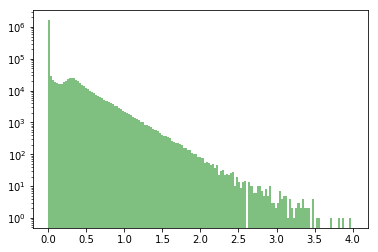

In [2]:
img = nib.load('/home/miquel/ForMiquel/CLEAN2/W_jacobian_100_5000.nii.gz')
img = img.get_data()
img = np.reshape(img,(121*145*121,1))
print(np.amax(img))
plt.figure(1)
bins = np.linspace(0, 4, 150)
plt.hist(img, bins, facecolor='green', alpha=0.5, normed=False, log=True)
#plt.xlabel('age_bl')
#plt.ylabel('appeareances')
#plt.title('age distribution of control subjects')
plt.show()


In [7]:
a=[1,2,3,0.8,1.2]
count_vals = sum(i > 1.2 for i in img)
print(count_vals/len(img)*100)

[ 0.60449046]
